# Searching

When the correct action to take is not immediately obvious, an agent may need to to **plan ahead**: to consider a sequence of actions that form a path to a goal state. Such an agent is called a **problem-solving agent**, and the computational process it undertakes is called **search**. As a running example, imagine an agent on a trip in Romania. The agent must reach Bucharest and it is currently in Arad, with three possible roads leading to Sibiu, Timisoara, and Zerind. Without knowledge of Romania geography, choosing the right path is unclear. If no additional information is available, the agent can only act randomly. This sad situation has to be addressed with more advanced method. 

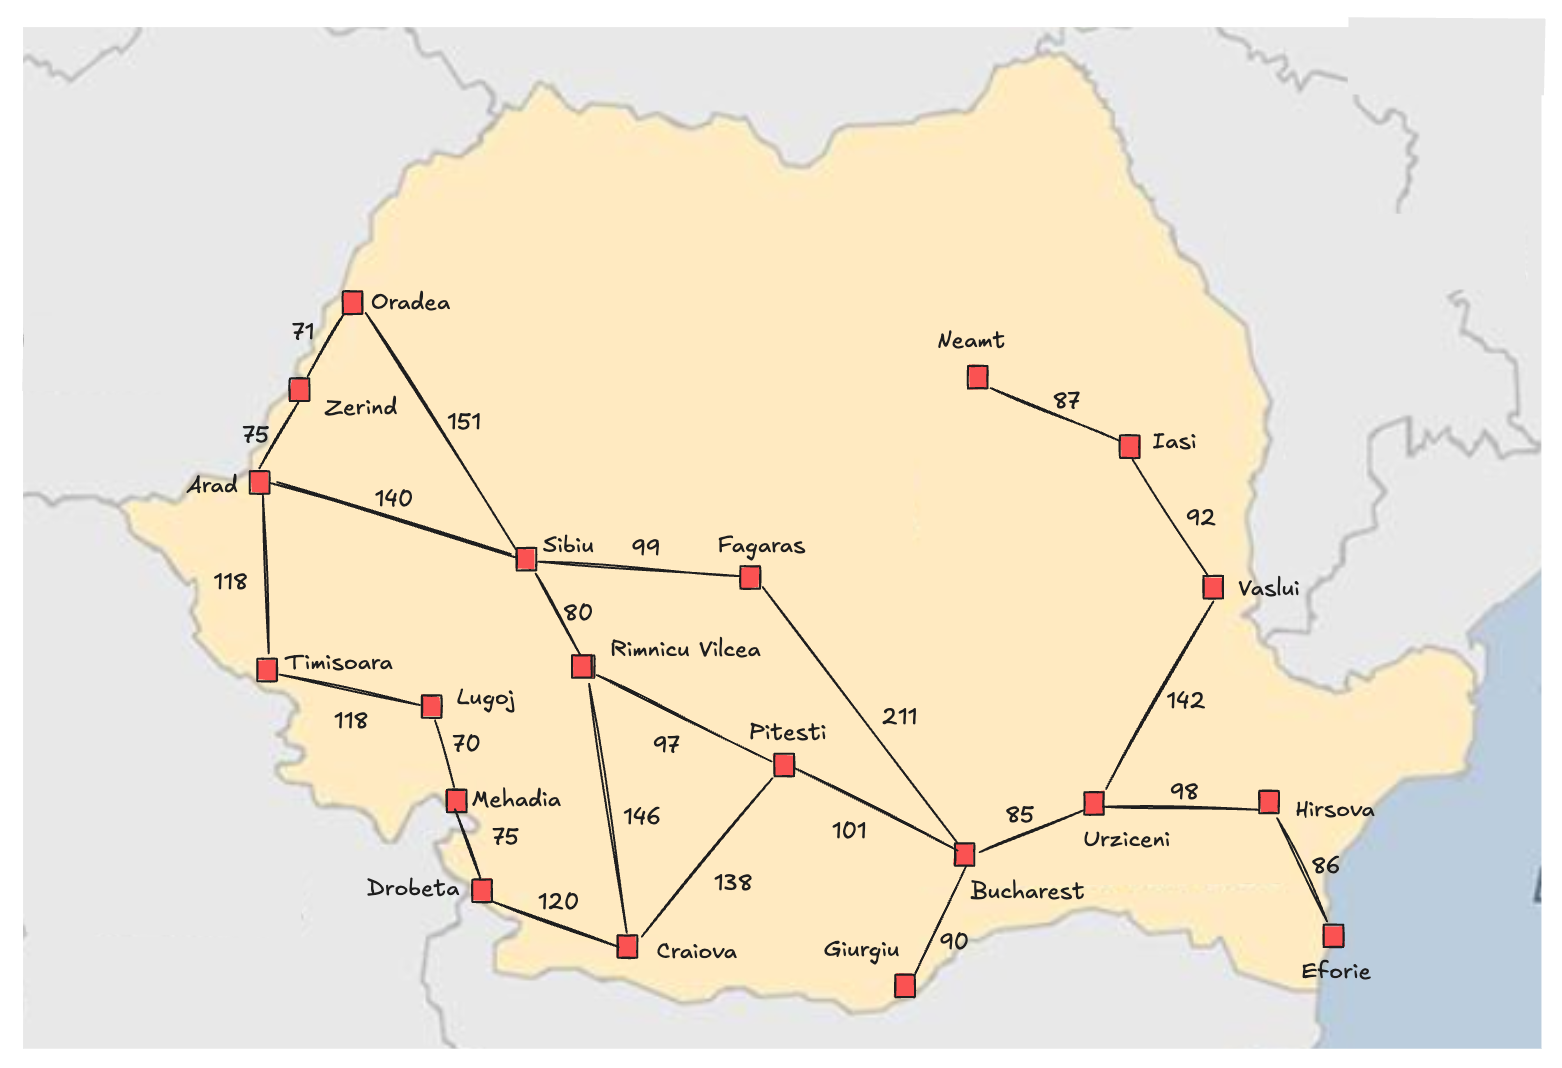

However, with access to a map, the agent can approach the task systematically using a four-phase problem-solving process:

- **Goal formulation**: defines objectives and limits actions. Here, the goal is to reach Bucharest.  
- **Problem formulation**: creates an abstract model of states and actions needed to achieve the goal. In this case, actions involve traveling between cities, with the current city being the only changing factor.  
- **Search**: simulates possible action sequences in its model to find a **solution**, a path leading to the goal (e.g., Arad -> Sibiu -> Fagaras -> Bucharest). It may explore unsuccessful paths before finding a valid one or determining no solution exists.  
- **Execution**: follows the solution, executing actions step by step.

In a fully observable, deterministic, and known environment, the solution is a fixed sequence of actions (e.g., drive to Sibiu, then Fagaras, then Bucharest). If the model is accurate, the agent can ignore percepts during execution since success is guaranteed. This is an **open-loop system**, where the agent does not adjust to new inputs. However, if the model is uncertain or the environment is non-deterministic, a **closed-loop approach** is safer, continuously monitoring percepts. In partially observable or unpredictable settings, solutions take the form of **branching strategies**, adapting actions based on new information. For instance, if the agent plans to drive to Sibiu but encounters a "Road Closed" sign, a **contingency plan** is needed.

## Graph structure

The information about the problem can be represented as a **graph**, where **nodes are states** and **edges are actions**, like the map of Romania. We can implement this idea in Python:

In [132]:
class Graph:
    def __init__(self, graph_dict=None):
        self.graph_dict = graph_dict or {}
        
    def connect_one(self, A, B, distance):
        """Add a link from A to B of given distance"""
        self.graph_dict.setdefault(A, {})[B] = distance
        self.graph_dict.setdefault(B, {})[A] = distance

    def get(self, a, b=None):
        """Return a link distance or a dict of {node: distance} entries.
        .get(a,b) returns the distance or None;
        .get(a) returns a dict of {node: distance} entries, possibly {}."""
        links = self.graph_dict.setdefault(a, {})
        if b is None:
            return links
        else:
            return links.get(b)

    def nodes(self):
        """Return a list of nodes in the graph."""
        s1 = set([k for k in self.graph_dict.keys()])
        s2 = set([k2 for v in self.graph_dict.values() for k2, v2 in v.items()])
        nodes = s1.union(s2)
        return list(nodes)

The constructor call is something like:

In [133]:
g = Graph({'A': {'B': 1, 'C': 2}})

This makes an undirected graph, so inverse links are also added. As an exmaple, the map of Romania problem can be represented as:

In [134]:
romania_map = Graph()

romania_map.connect_one('Arad', 'Zerind', 75)
romania_map.connect_one('Arad', 'Timisoara', 118)
romania_map.connect_one('Arad', 'Sibiu', 140)
romania_map.connect_one('Zerind', 'Oradea', 71)
romania_map.connect_one('Oradea', 'Sibiu', 151)
romania_map.connect_one('Timisoara', 'Lugoj', 111)
romania_map.connect_one('Lugoj', 'Mehadia', 70)
romania_map.connect_one('Mehadia', 'Drobeta', 75)
romania_map.connect_one('Drobeta', 'Craiova', 120)
romania_map.connect_one('Craiova', 'Rimnicu Vilcea', 146)
romania_map.connect_one('Craiova', 'Pitesti', 138)
romania_map.connect_one('Sibiu', 'Rimnicu Vilcea', 80)
romania_map.connect_one('Sibiu', 'Fagaras', 99)
romania_map.connect_one('Rimnicu Vilcea', 'Pitesti', 97)
romania_map.connect_one('Fagaras', 'Bucharest', 211)
romania_map.connect_one('Pitesti', 'Bucharest', 101)
romania_map.connect_one('Bucharest', 'Giurgiu', 90)
romania_map.connect_one('Bucharest', 'Urziceni', 85)
romania_map.connect_one('Urziceni', 'Hirsova', 98)
romania_map.connect_one('Hirsova', 'Eforie', 86)
romania_map.connect_one('Urziceni', 'Vaslui', 142)
romania_map.connect_one('Vaslui', 'Iasi', 92)
romania_map.connect_one('Iasi', 'Neamt', 87)

We can get the successors of a node with:

In [135]:
romania_map.get('Sibiu')

{'Arad': 140, 'Oradea': 151, 'Rimnicu Vilcea': 80, 'Fagaras': 99}

## Problem formulation

In general, the search problem can be defined as a tuple **(S, A, T, I, G)**, where: 

- **S** is the **state space**, representing all possible states the environment can be in (e.g. "Sibiu", "Arad", "Bucharest", etc.).
- **A** is the set of **available actions** in a state (e.g., "go to Sibiu" when in "Arad").
- **T** is the **transition model**, which defines the result of applying an action in a state (e.g., "go to Sibiu" in "Arad" leads to "Sibiu").
- **I** is the **initial state**, where the agent starts (e.g., "Arad").
- **G** is the set of **goal states**, which can be a single state (e.g., "Bucharest"), a set of alternative states, or defined by a property (e.g., no dirt in the vacuum-cleaner world).
- **C** if the **cost function**, which assigns a numeric cost to applying an action (e.g., travel time or distance).

The information about the problem can be given using an **explicit graph**, such as the map of Romania. But in many problems, the graph is represented **only implicitly** by the initial state, actions, and transition model. For the explicit case, we can implement the problem in Python exploiting the graph structure:

In [136]:
class Problem:
    """The abstract class for a formal problem."""

    def __init__(self, initial, goal=None):
        """The constructor specifies the initial state, and possibly a goal
        state, if there is a unique goal."""
        self.initial = initial
        self.goal = goal

    def actions(self, state):
        """Return the actions that can be executed in the given state. """
        raise NotImplementedError

    def result(self, state, action):
        """Return the state that results from executing the given
        action in the given state."""
        raise NotImplementedError

    def goal_test(self, state):
        """Return True if the state is a goal."""
        raise NotImplementedError

    def path_cost(self, c, state1, action, state2):
        """Return the cost of a path that arrives at state2 from
        state1 via action"""
        raise NotImplementedError

    def value(self, state):
        """For optimization problems, each state can have a value."""
        raise NotImplementedError

A **path** is a sequence of actions, and a **solution** is a path from the initial state to a goal state. Action costs are assumed to be additive, meaning the total cost is the sum of individual action costs. An **optimal solution** has the **lowest path cost** among all solutions. All action costs are positive to avoid complications. The state space can be represented as a **graph**, where **vertices are states** and **directed edges are actions**, like the map of Romania:

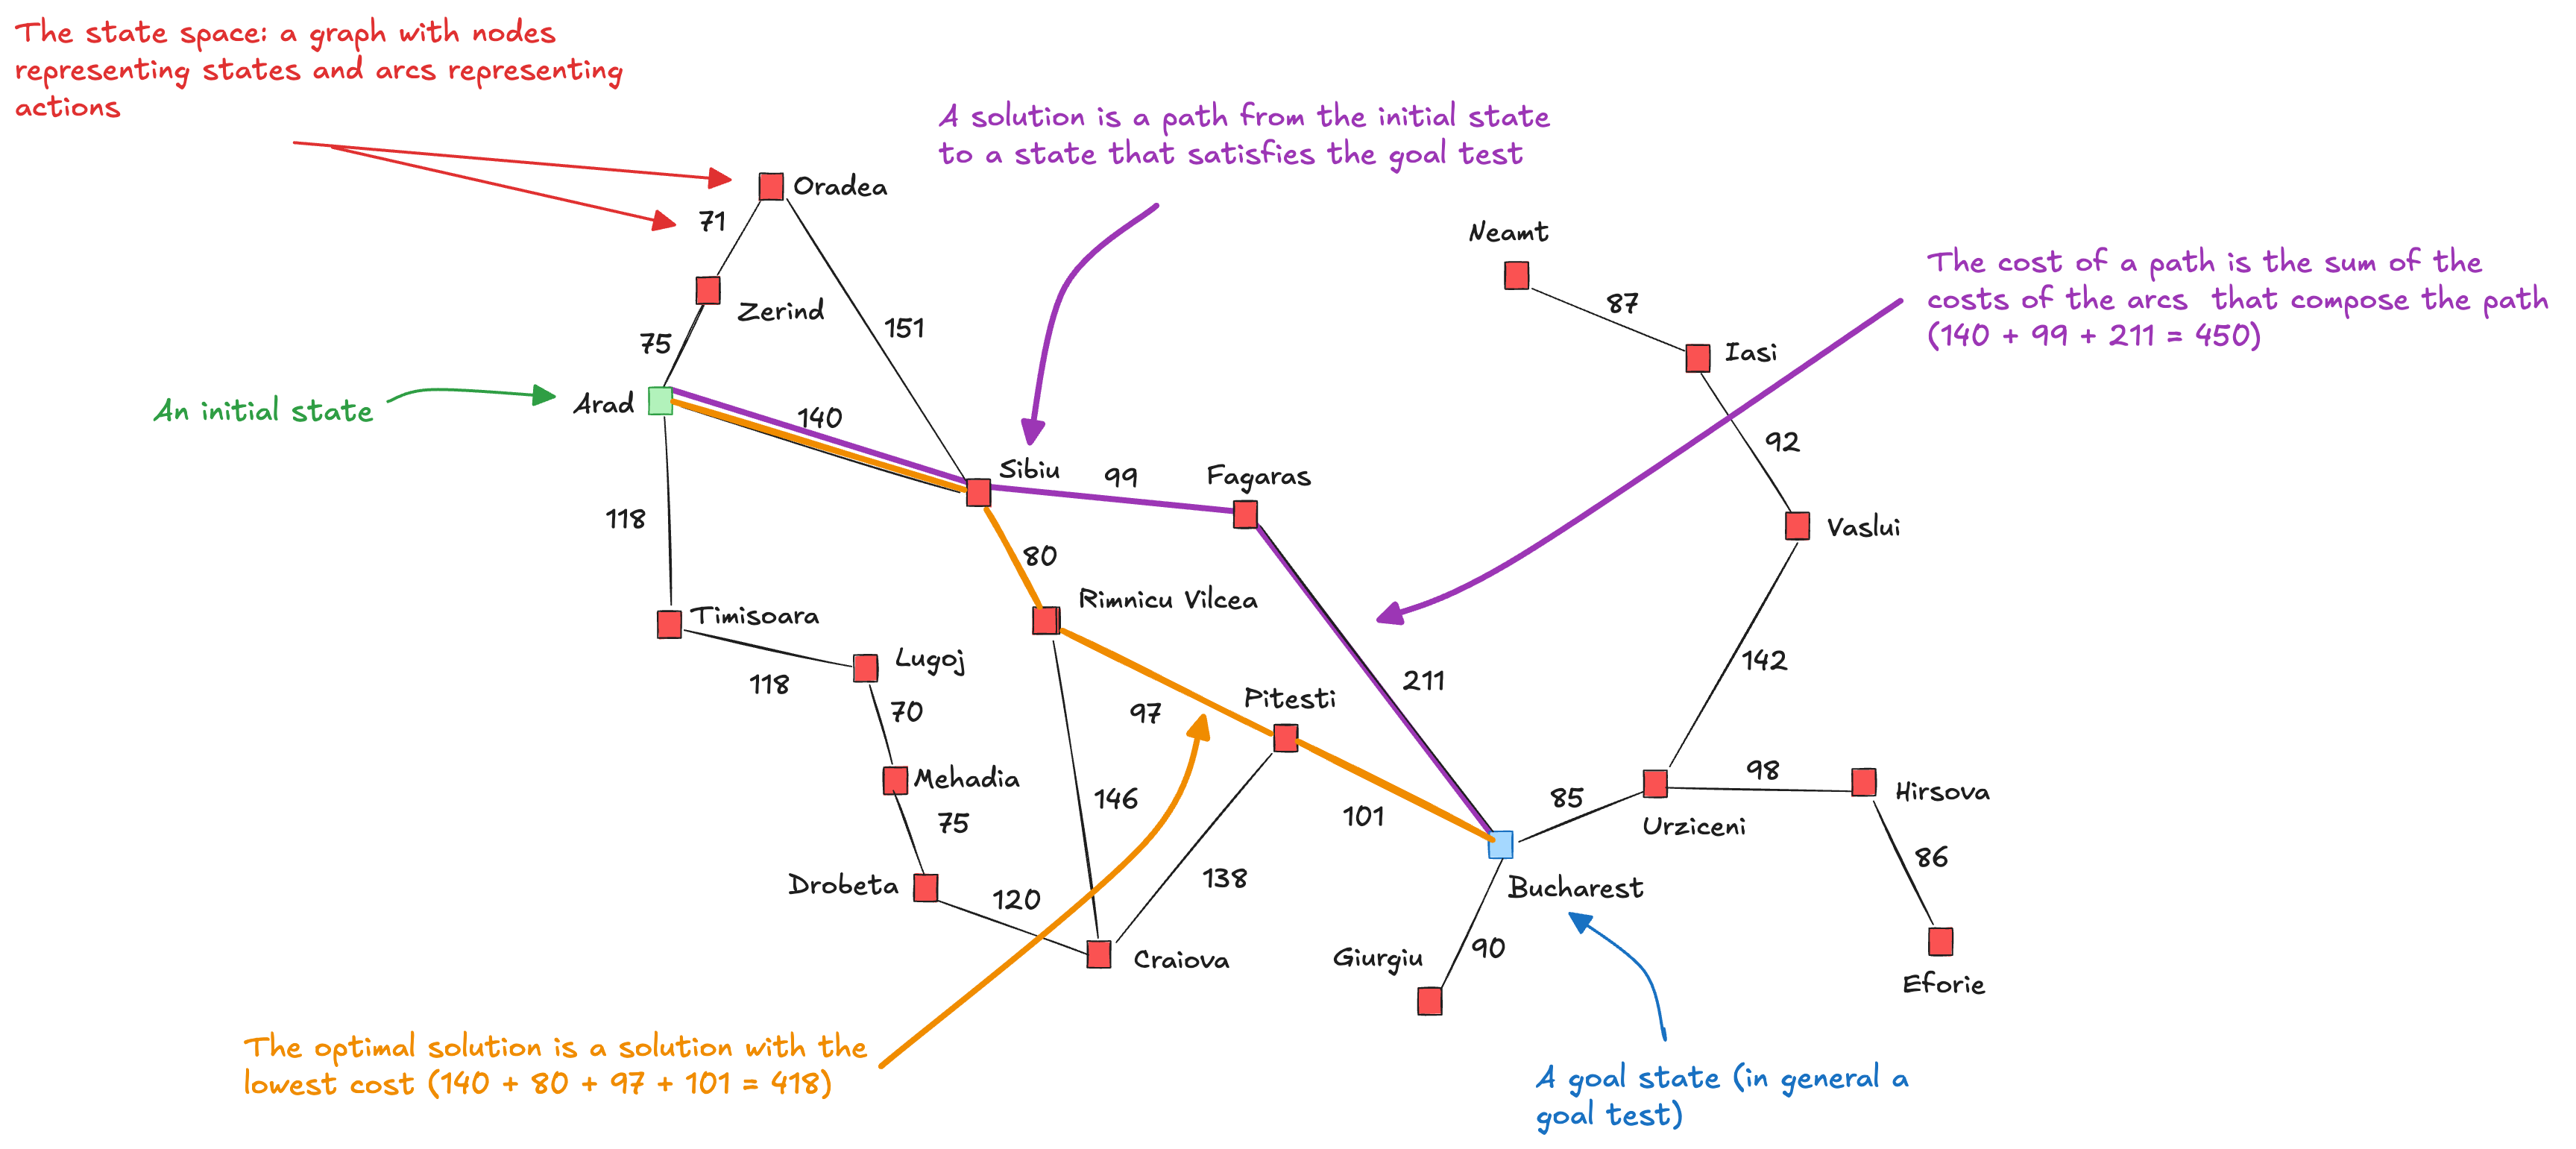

This problem formulation is an **abstract model**, not a reflection of reality. For example, the simple state "Arad" omits many real-world factors, such as traveling companions, weather, and traffic, which are deemed **irrelevant** for finding a route to Bucharest. The process of simplifying a representation is called **abstraction**, and a good problem formulation strikes the right **level of abstraction**. If actions were overly detailed, like "move the right foot forward a centimeter", the agent would struggle to solve the problem. The abstraction is valid if any abstract solution can be mapped to a feasible detailed solution. For example, driving from "Arad" to "Sibiu" don't require any additional planning. A good abstraction **removes unnecessary detail while ensuring actions remain simple and valid**. Without useful abstractions, intelligent agents would be overwhelmed by complexity We can implment the search problem where the information are given as a graph:

In [137]:
class GraphProblem(Problem):
    """The problem of searching a graph from one node to another."""

    def __init__(self, graph, initial, goal):
        super().__init__(initial, goal)
        self.graph = graph

    def actions(self, action):
        """The actions at a graph node are just its neighbors."""
        return list(self.graph.get(action).keys())

    def result(self, state, action):
        """The result of going to a neighbor is just that neighbor."""
        return action
    
    def goal_test(self, state):
        """Return True if the state is a goal."""
        if isinstance(self.goal, list):
            return is_in(state, self.goal)
        else:
            return state == self.goal

    def path_cost(self, cost_so_far, A, action, B):
        return cost_so_far + (self.graph.get(A, B) or np.inf)

So the problem of searching a path from Arad to Bucharest on the Romania map can be expresssed as:

In [138]:
romania_problem = GraphProblem(romania_map, "Arad", "Bucharest")

## Problem  examples

We can design some **standardized problem** to showcase or test different problem-solving methods. With a clear and precise description, it serves as a **benchmark** for researchers to compare the performance of algorithms in real-world scenarios. We can then have real-world problems.

### Grid world

A **grid world problem** is a two-dimensional array of cells where agents can move horizontally, vertically, or sometimes diagonally between adjacent cells. Cells may contain objects that the agent can interact with, while walls or obstacles block movement. The vacuum cleaning world is an example of a grid world problem:

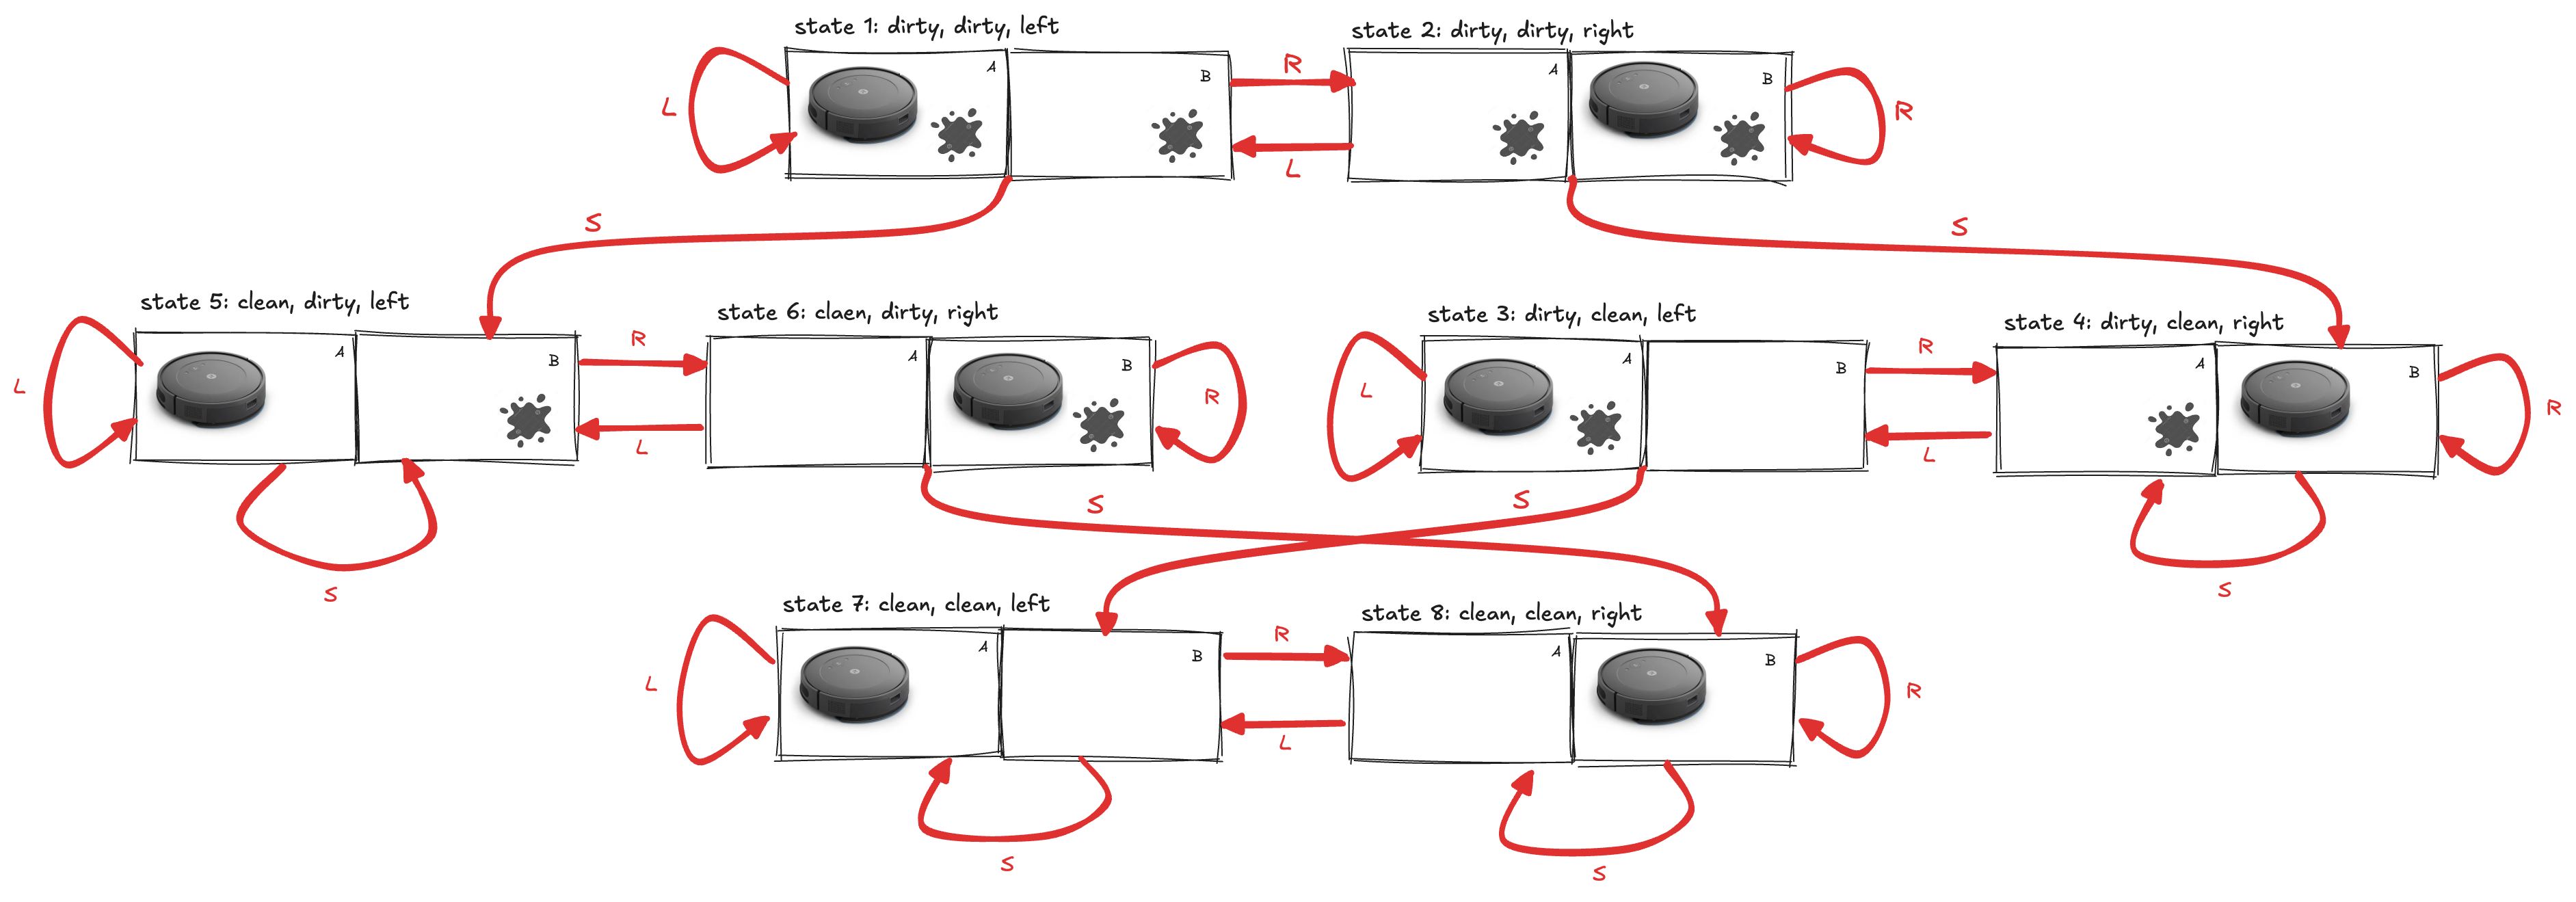

We can define the problem as follows:
- State space: a state specifies object locations, including the agent and dirt. In a two-cell world, the agent can be in either cell, and each cell may contain dirt, yielding 8 states. Generally, with \(N\) cells, there are \(N \times 2^N\) states.  
- Initial state: any state.  
- Actions: auck, move left, and move right. In a 2D grid, additional moves (up/down) are needed.  
- Transition model: sauck removes dirt; movement shifts the agent unless blocked by a wall.  
- Goal function: all cells are clean  
- Cost function: each action costs 1

The problem can be explicitly defined using a grpah structure:

In [139]:
vacuum_world = Graph(dict(
    State_1=dict(Suck=['State_5'], Left=['State_1'], Right=['State_2']),
    State_2=dict(Suck=['State_4'], Left=['State_1'], Right=['State_2']),
    State_3=dict(Suck=['State_7'], Left=['State_3'], Right=['State_4']),
    State_4=dict(Suck=['State_4'], Left=['State_3'], Right=['State_4']),
    State_5=dict(Suck=['State_5'], Left=['State_5'], Right=['State_6']),
    State_6=dict(Suck=['State_8'], Left=['State_5'], Right=['State_6']),
    State_7=dict(Suck=['State_7'], Left=['State_7'], Right=['State_8']),
    State_8=dict(Suck=['State_8'], Left=['State_7'], Right=['State_8'])
))

vacuum_problem = GraphProblem(vacuum_world, "State_1", "State_7")

### Sliding-tile puzzle

Another type of grid world is the **sliding-tile puzzle**, where a several numberd tiles (e.g. 8, 15) are arranged in a grid (e.g. 3x3, 4X4) with one blank space so that some of the tiles can slide into the blank space. The goal is to reach a ordered configuration of the tiles from a given initial configuration:

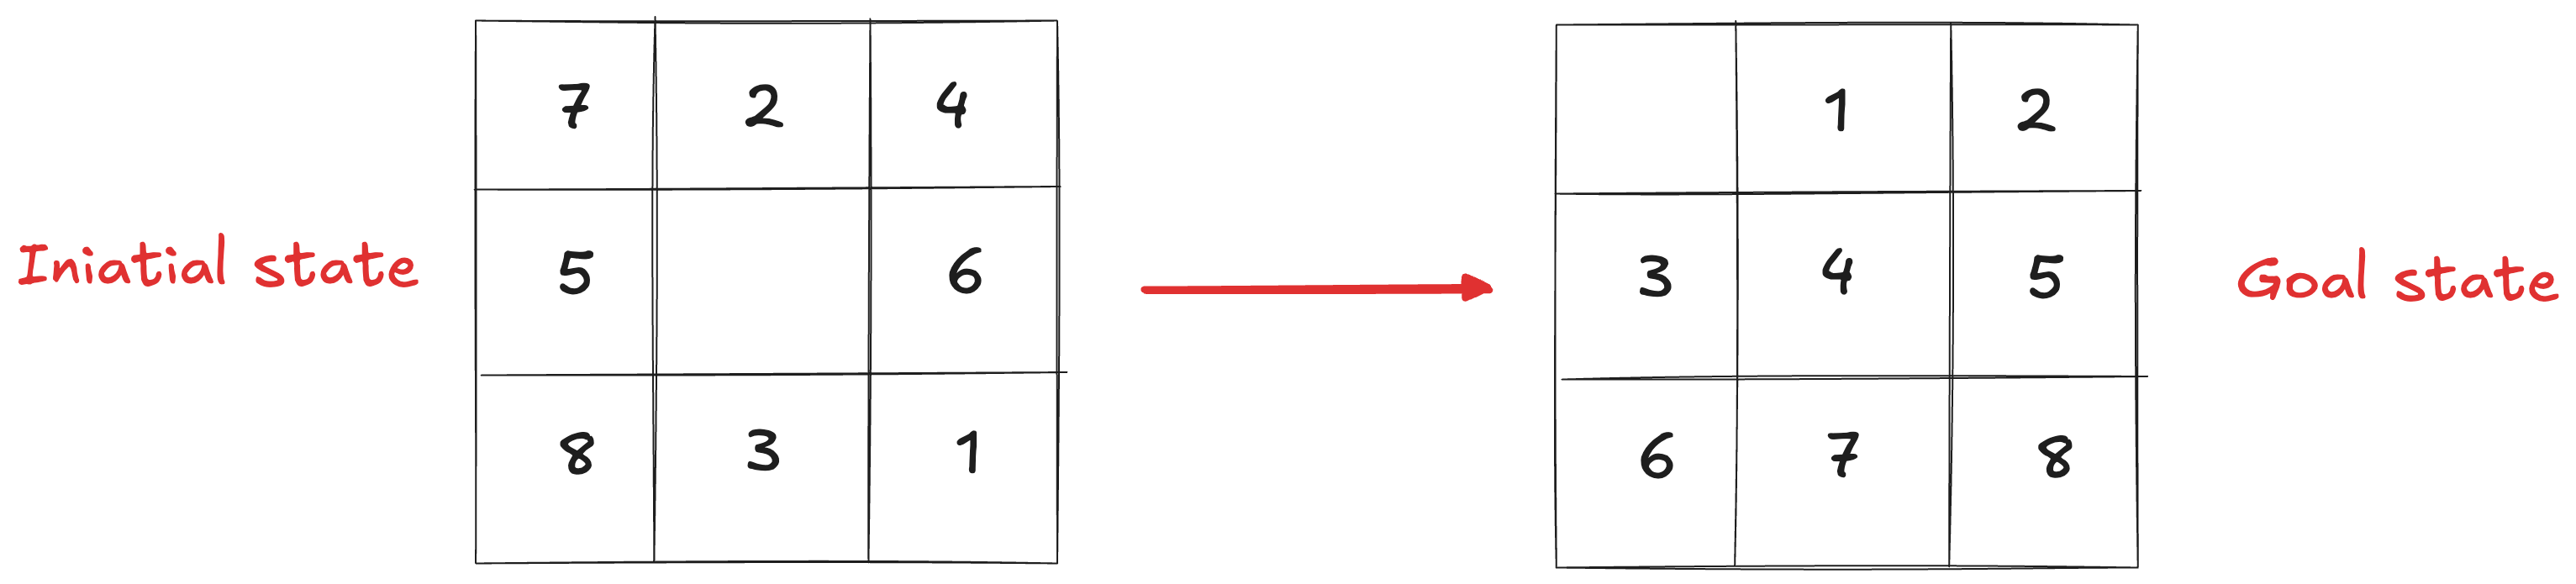

We can define the problem as follows:
- State space: defines the location of each tile.  
- Initial state: any state can be the starting point.  
- Actions: the blank space moves left, right, up, or down, unless blocked by an edge or corner.  
- Transition model: maps a state and action to a new state (e.g., moving left swaps the blank with the adjacent tile).  
- Goal test tiles arranged in numerical order.  
- Cost function: each action costs 1.

In that case, altought it is possible to represent the problem explicitly creating a graph, it is more convinient and efficient an implicit representation that consider the position of the blank space:

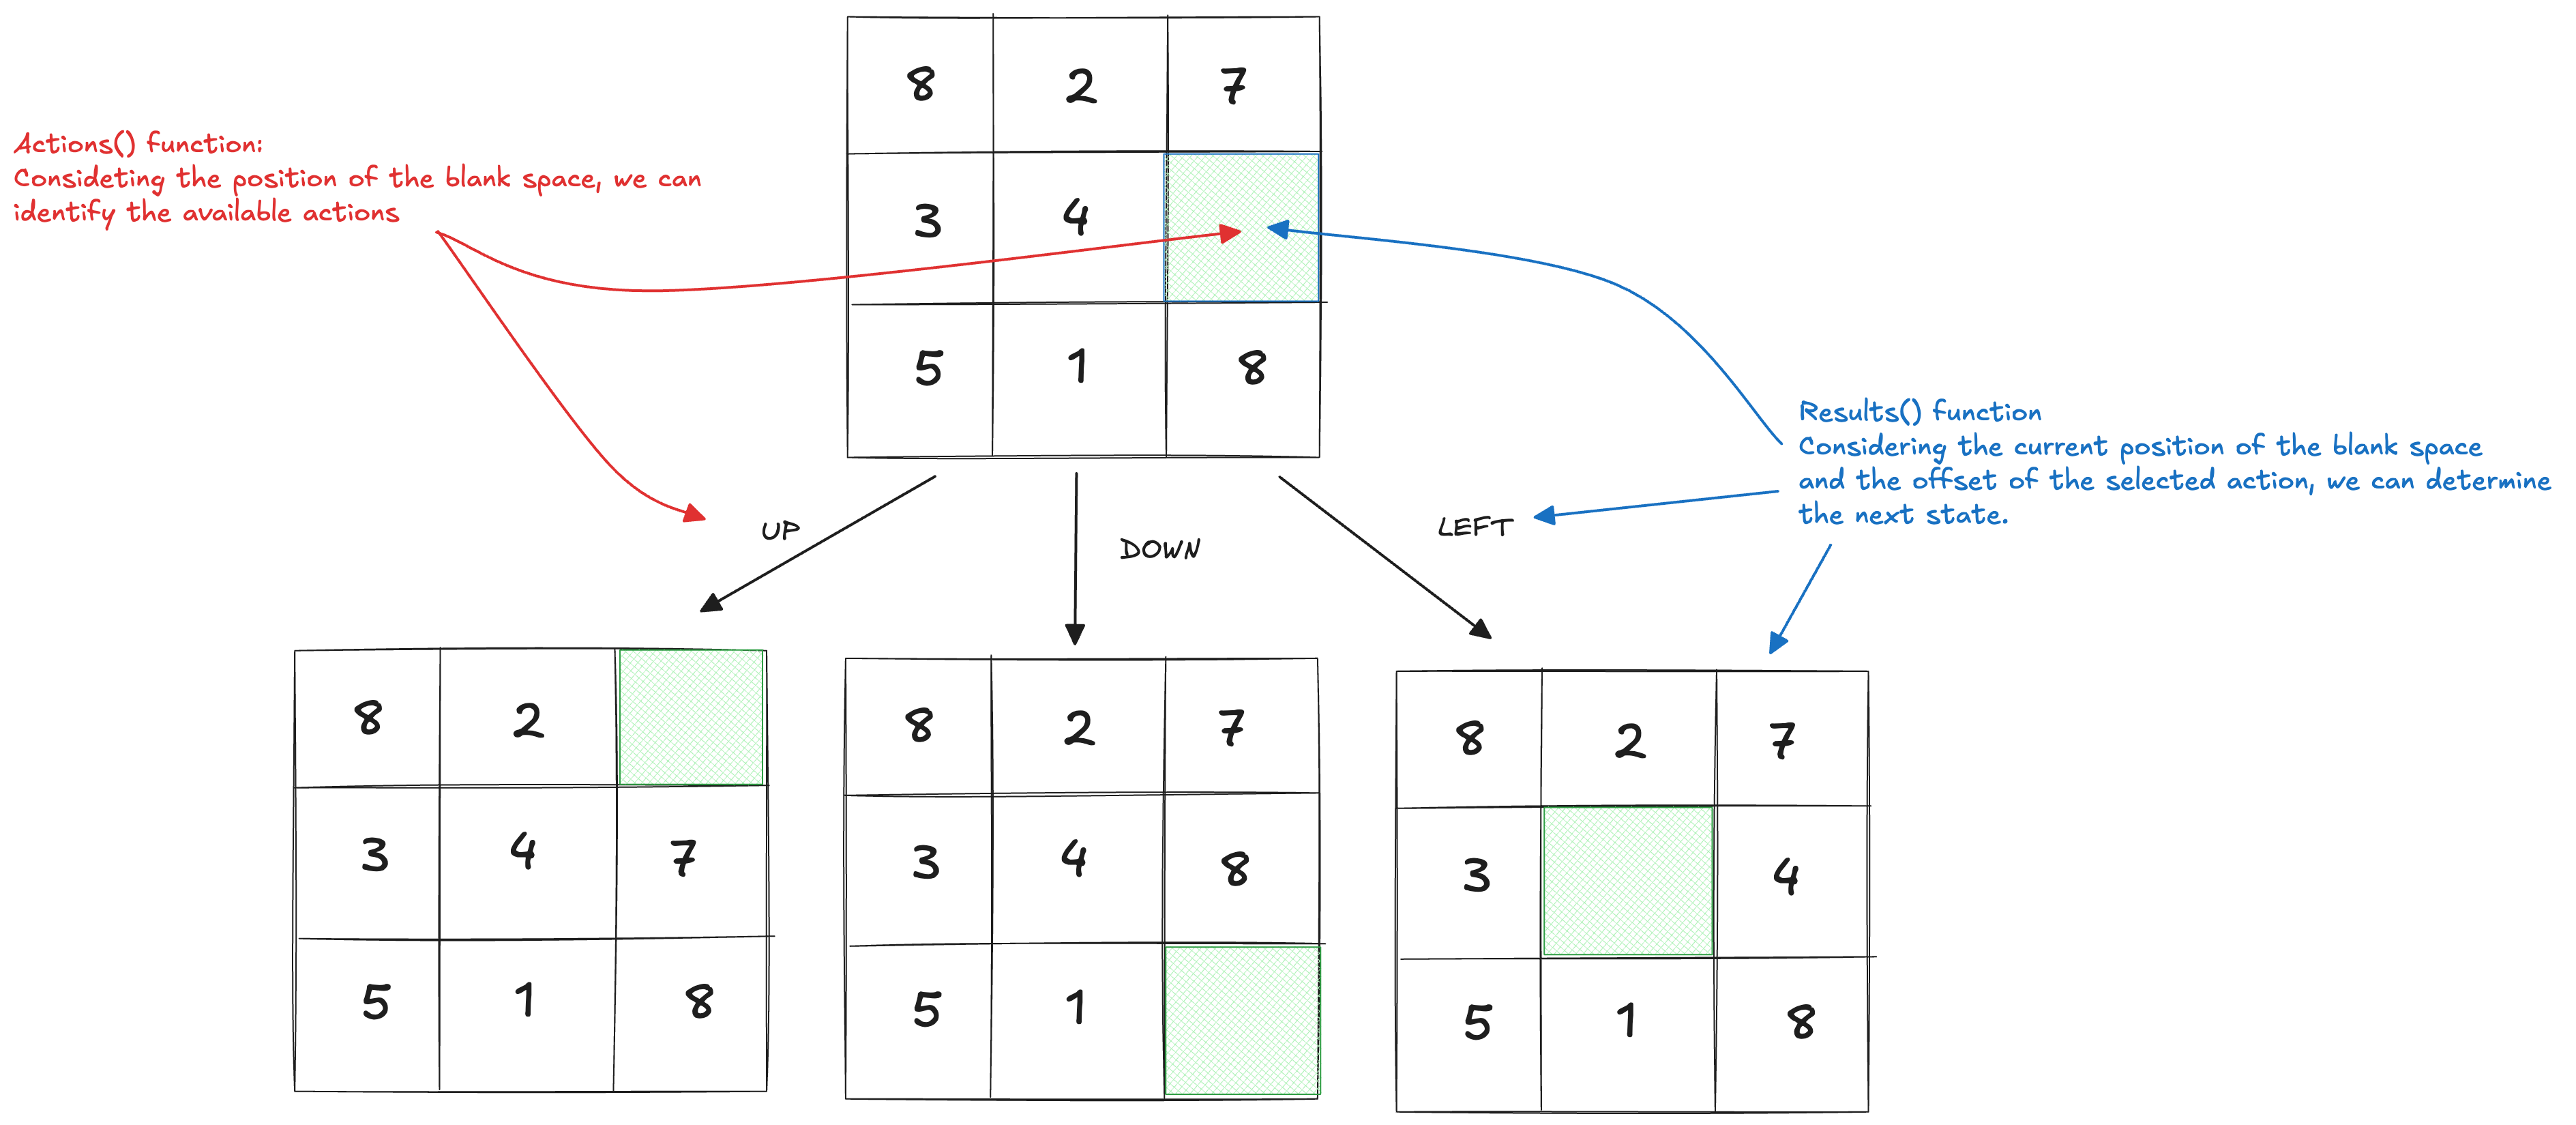

In [140]:
class EightPuzzle(Problem):

    def __init__(self, initial, goal=(1, 2, 3, 4, 5, 6, 7, 8, 0)):
        super().__init__(initial, goal)

    def find_blank_square(self, state):
        return state.index(0)

    def actions(self, state):
        # All possible actions
        possible_actions = ['UP', 'DOWN', 'LEFT', 'RIGHT']

        # Restrict actions based on blank tile position
        index_blank_square = self.find_blank_square(state)
        if index_blank_square % 3 == 0:
            possible_actions.remove('LEFT')
        if index_blank_square < 3:
            possible_actions.remove('UP')
        if index_blank_square % 3 == 2:
            possible_actions.remove('RIGHT')
        if index_blank_square > 5:
            possible_actions.remove('DOWN')
            
        return possible_actions

    def result(self, state, action):

        # Find the blank tile index
        blank = self.find_blank_square(state)

        # Convert to list for mutability
        new_state = list(state)

        # Define movement shifts based on action
        delta = {'UP': -3, 'DOWN': 3, 'LEFT': -1, 'RIGHT': 1}

        # Compute new blank position
        neighbor = blank + delta[action]

        # Swap blank tile with its neighbor
        new_state[blank], new_state[neighbor] = new_state[neighbor], new_state[blank]

        # Convert back to tuple (immutable state representation)
        return tuple(new_state)

    def goal_test(self, state):
        return state == self.goal

    def path_cost(self, c, state1, action, state2):
        return c + 1

Notice that every problem formulation includes abstractions. In the 8-puzzle, actions are defined by start and end positions, ignoring the tile's movement. We exclude actions like shaking the board or manually repositioning tiles, focusing only on rule-based moves.

### Eight-queens puzzle

The **eight-queens puzzle** is a combinatorial problem that requires placing **eight queens** on an **8×8 chessboard** so that no two queens attack each other, meaning no two queens share the same **row, column, or diagonal**:

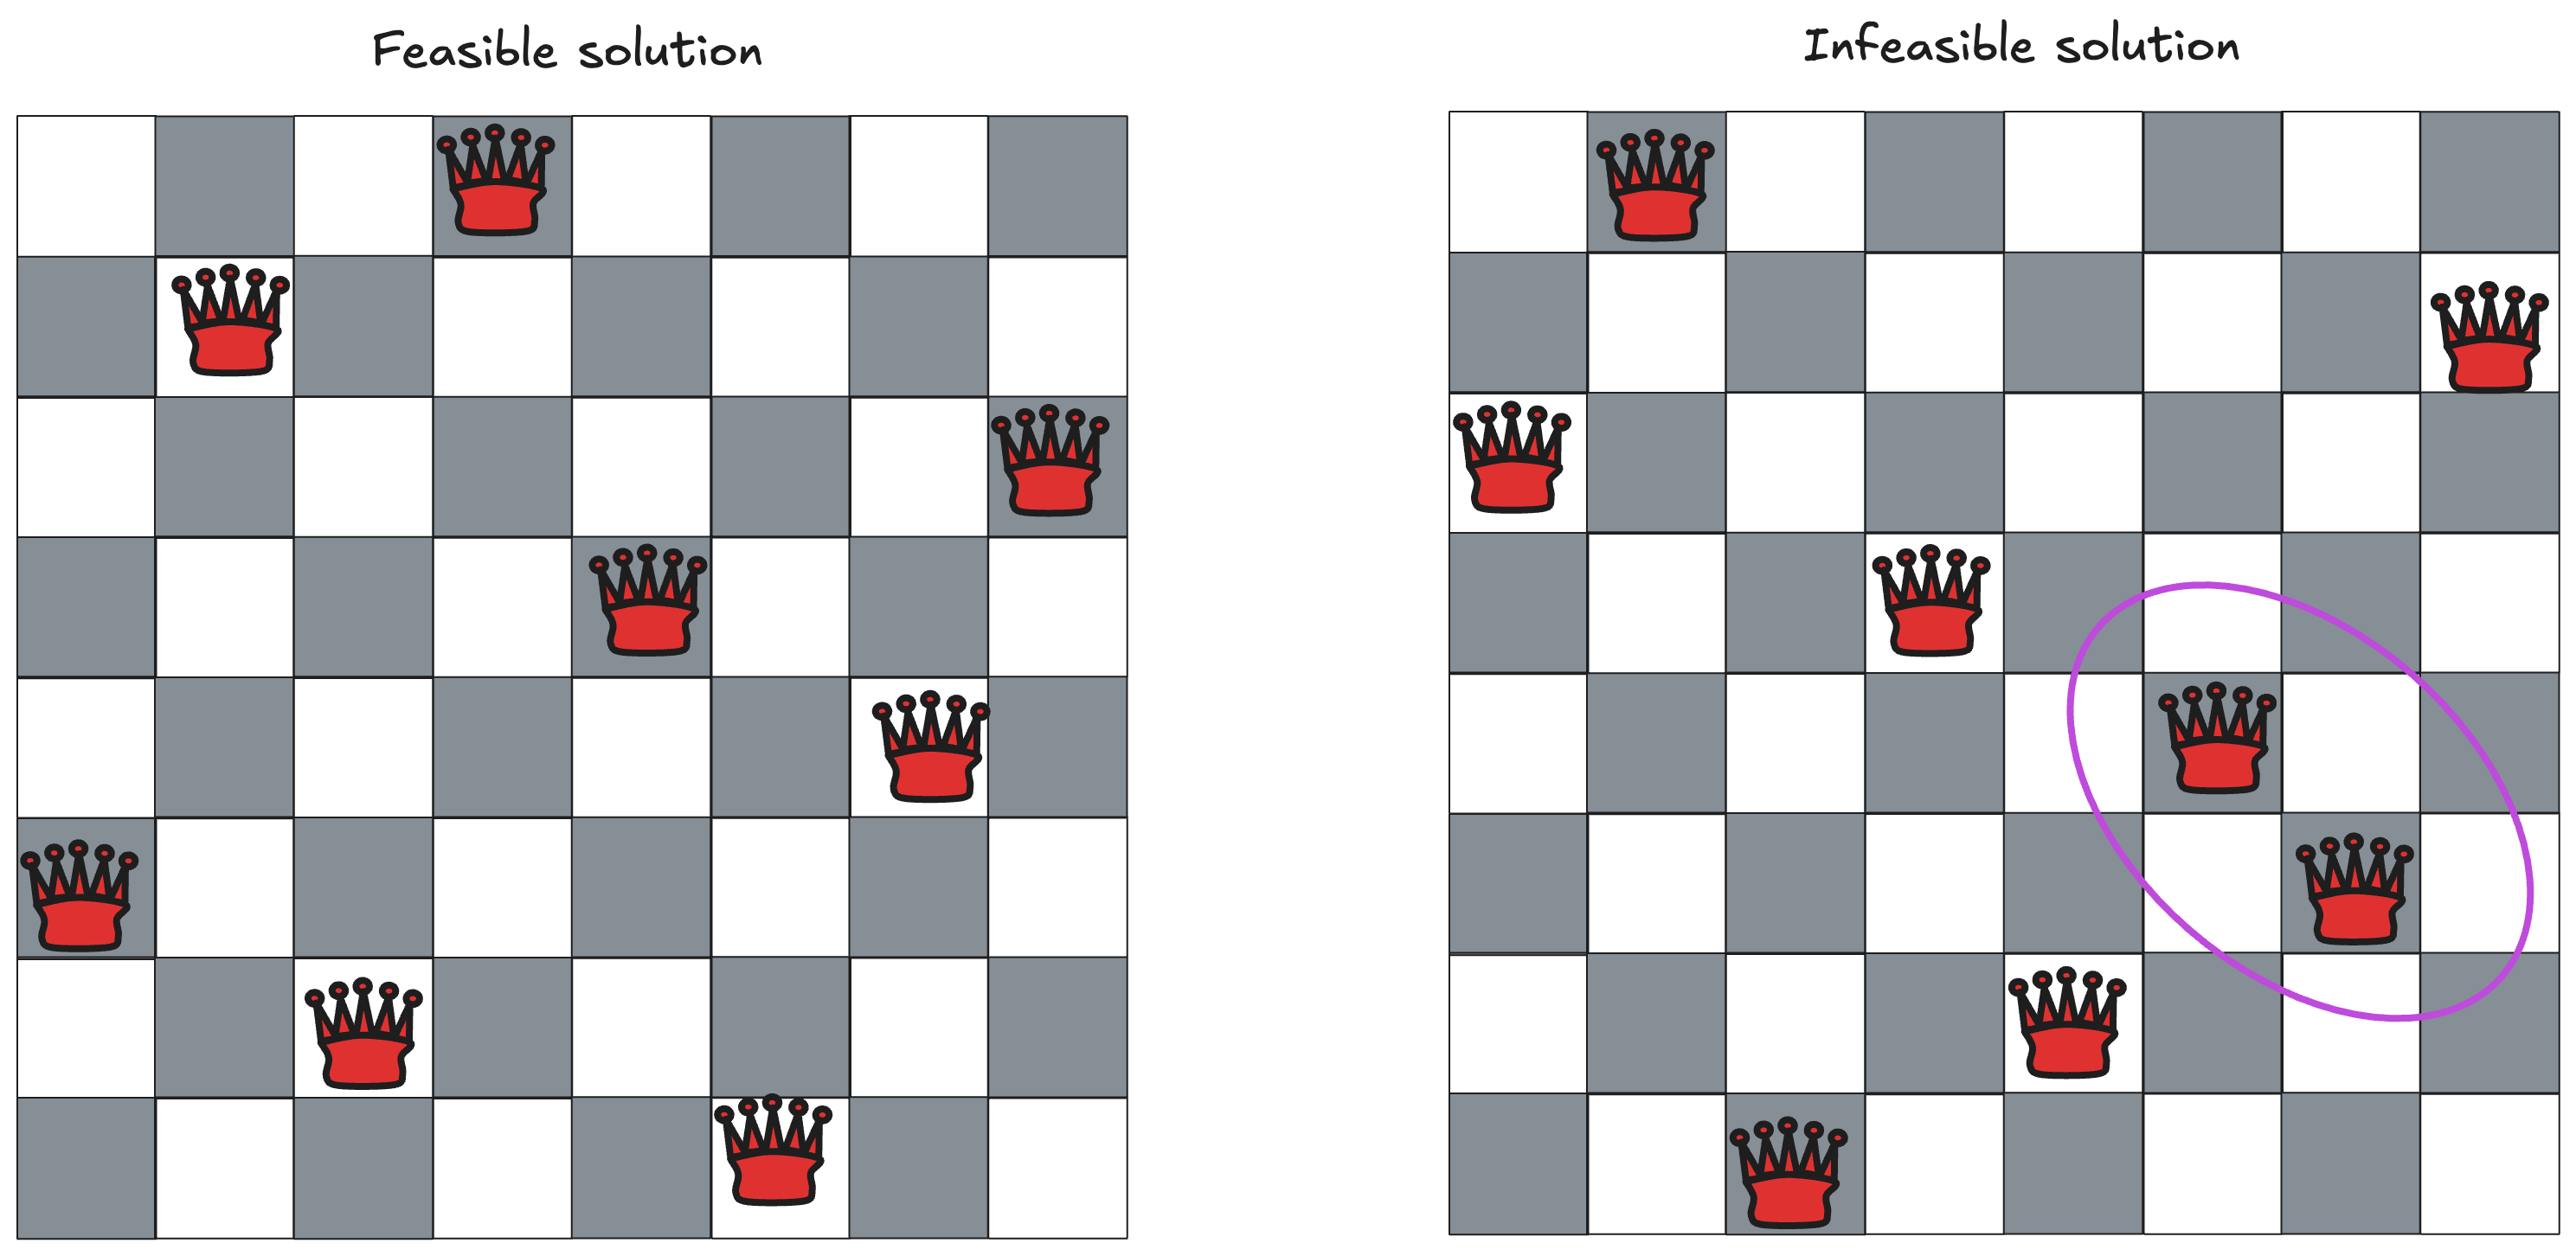

The problem can be defined as follows:  

- State space: all possible placements of 0 to 8 queens on the board, totaling approximately 1.8*10^14 states (64x63x...x57). A state is represented as an N-element array, where a value of r in the c entry means there is a queen at column c, row r, and a value of -1 means that the c column has not been filled in yet 
- Initial state: an empty chessboard. The initial state is an array with -1 in all entries. 
- Actions: placing a queen in a column that does not already have one . 
- Transition model: places a queen in the next available row of the column.  
- Goal test: checks that no two queens are in the same row, column, or diagonal.  
- Cost function: each action has a uniform cost of 1 (though this is irrelevant in this context).  

Let's implement the problem in Python:

In [165]:
class NQueensProblem(Problem):
    """The problem of placing N queens on an NxN board with none attacking each other."""

    def __init__(self, N):
        super().__init__(tuple([-1] * N))
        self.N = N

    def actions(self, state):
        """In the leftmost empty column, try all non-conflicting rows."""
        if state[-1] != -1:
            return []  # All columns filled; no successors
        else:
            col = state.index(-1)
            return [row for row in range(self.N)
                    if not self.conflicted(state, row, col)]

    def result(self, state, row):
        """Place the next queen at the given row."""
        col = state.index(-1)
        new = list(state[:])
        new[col] = row
        return tuple(new)
    
    def conflict(self, row1, col1, row2, col2):
        """Would putting two queens in (row1, col1) and (row2, col2) conflict?"""
        return (row1 == row2 or  # same row
                col1 == col2 or  # same column
                row1 - col1 == row2 - col2 or  # same \ diagonal
                row1 + col1 == row2 + col2)  # same / diagonal

    def conflicted(self, state, row, col):
        """Would placing a queen at (row, col) conflict with anything?"""
        return any(self.conflict(row, col, state[c], c)
                   for c in range(col))

    def goal_test(self, state):
        """Check if all columns filled, no conflicts."""
        if state[-1] == -1:
            return False
        return not any(self.conflicted(state, state[col], col)
                       for col in range(len(state)))
    
    def path_cost(self, c, state1, action, state2):
        return c + 1

### Real-world problems

Many real-world problems can be framed as search tasks. From navigation systems to robotics and circuit design, efficient algorithms help find optimal solutions while managing complexity and constraints. Here some examples: 

- **Route-finding** problems involve navigating between specified locations via defined paths. Applications range from simple GPS navigation to complex scenarios like traffic-aware routing, military logistics, and airline travel planning, where factors like delays, rerouting, and fare structures add complexity.  

- **Touring problems** require visiting multiple locations instead of reaching a single goal. The **Traveling Salesperson Problem (TSP)** seeks the shortest possible tour covering all cities. Optimized TSP algorithms are widely used in logistics, including vehicle routing and supply chain management.  

- **VLSI layout** optimization positions millions of components on a chip to minimize space, circuit delays, and interference. The process is divided into **cell layout**, which arranges functional blocks, and **channel routing**, which determines wire connections between them.  

- **Robot navigation** generalizes route-finding by allowing movement in continuous space rather than fixed paths. Controlling robotic limbs adds complexity, turning the problem into a high-dimensional search. Real-world robots must also handle sensor errors, partial observability, and dynamic environments.  

- **Automatic assembly** sequencing determines the optimal order for assembling complex objects, such as electric motors, reducing costs and production time. A key challenge is ensuring feasibility at each step while avoiding redundant searches. A specialized case is **protein design**, where algorithms search for amino acid sequences that fold into functional proteins, with potential applications in medicine.

## Search Trees

A **search algorithm** takes a problem as input and returns either a solution or failure. Solutions are found by building a **search tree over the space state graph**, and exploring paths from the initial state to a goal. In the treen, each **node represents a path from the initial state to another state**, with **edges corresponding to actions**. The **root node** represents the initial state. **Expanding** a node involves applying available actions, using the result function to determine the resulting states, and generating **child nodes** (or **successors**). The algorithm then selects the next node to explore. We can define the **frontier** as the set of nodes that have been reached but not yet expanded. We can define **depth** of a node as the number of edges from the root to the node. The figure illustrates the initial steps in finding a path from Arad to Bucharest.

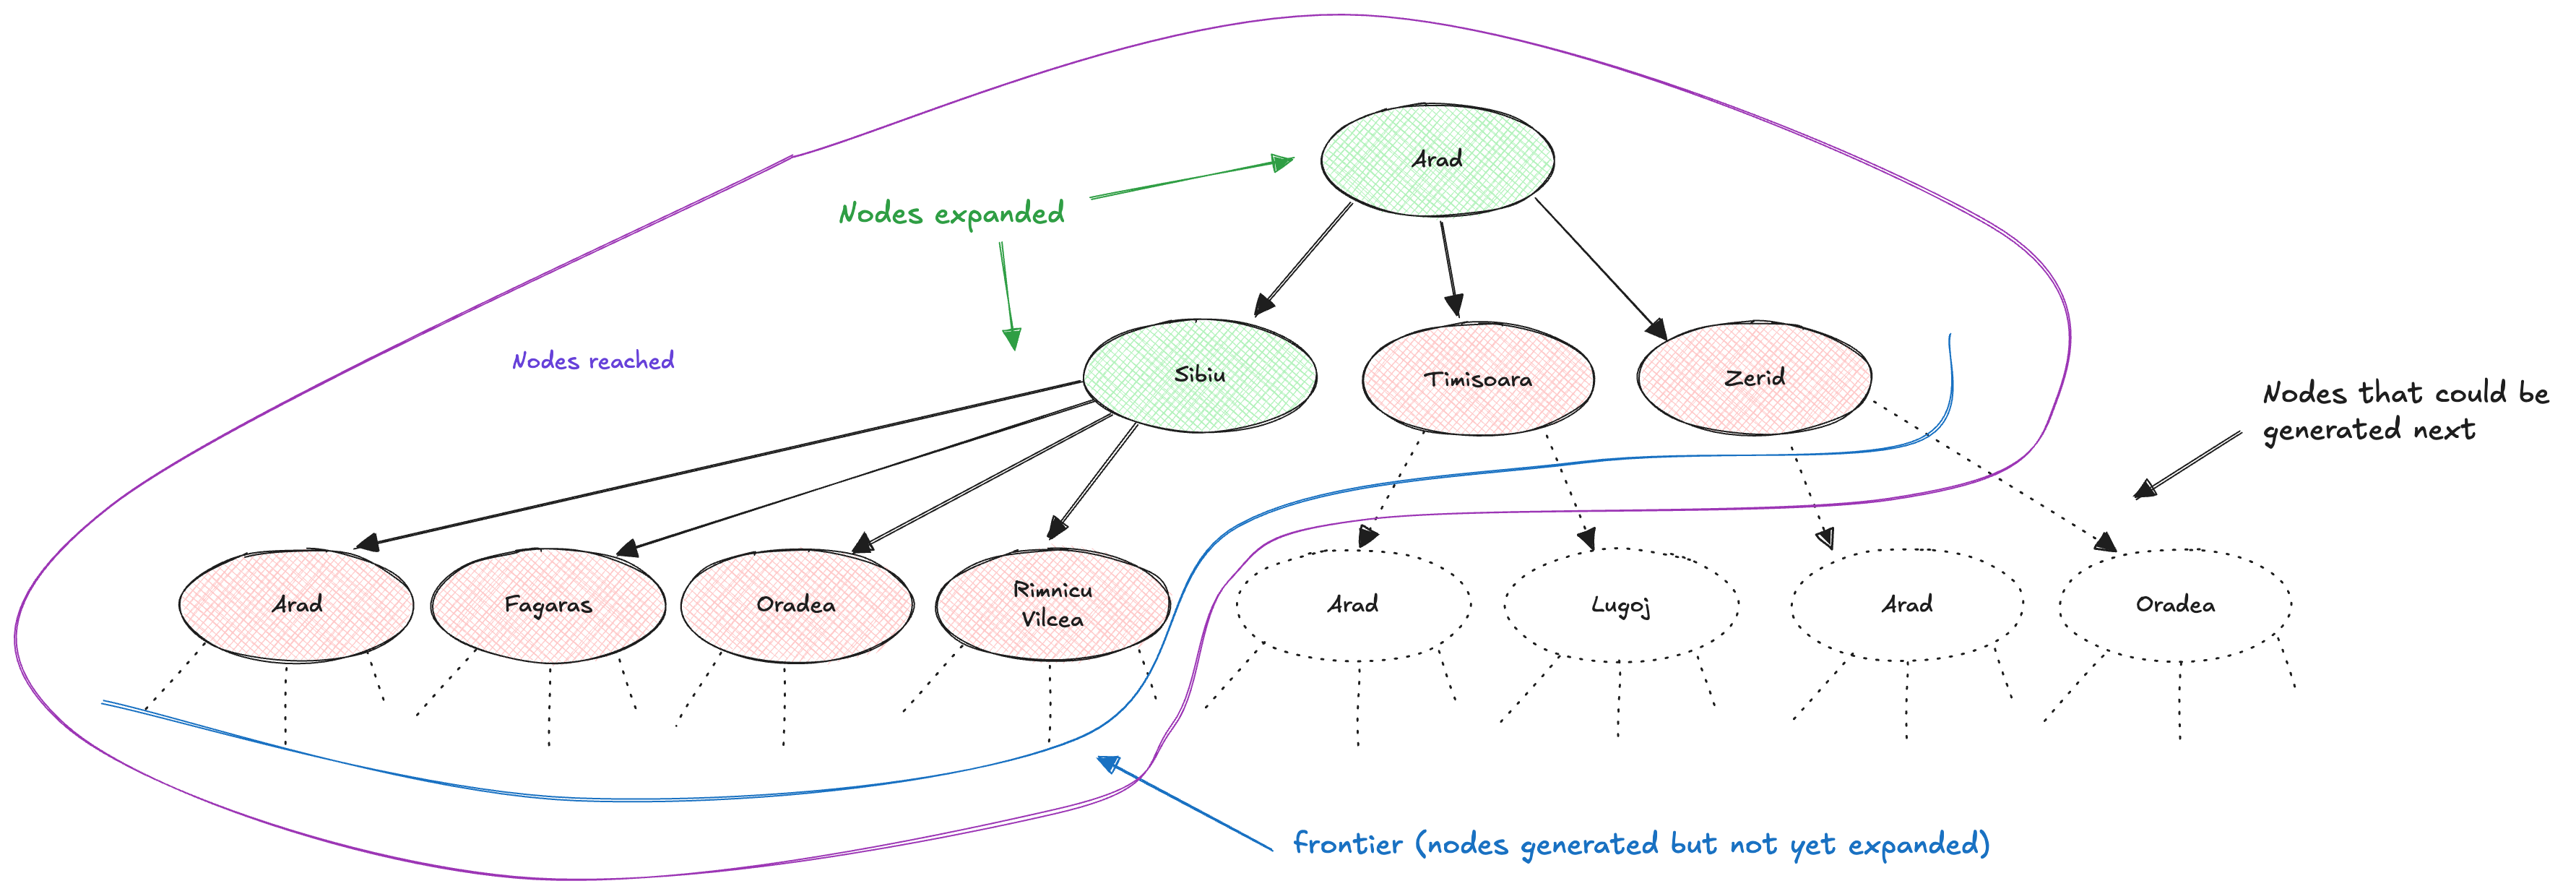

It is crucial to distinguish between the state space and the search tree. The **state space** encompasses all possible states and transitions within a given problem, while the **search tree** represents the exploration of different paths toward the goal. A single state in the state space may correspond to multiple nodes in the search tree if it can be reached via different paths from the initial state. If states can be revisited multiple times, the search tree may become infinite, even when the state space itself is finite.

We can consider the tree superimposed on the state-space graph:

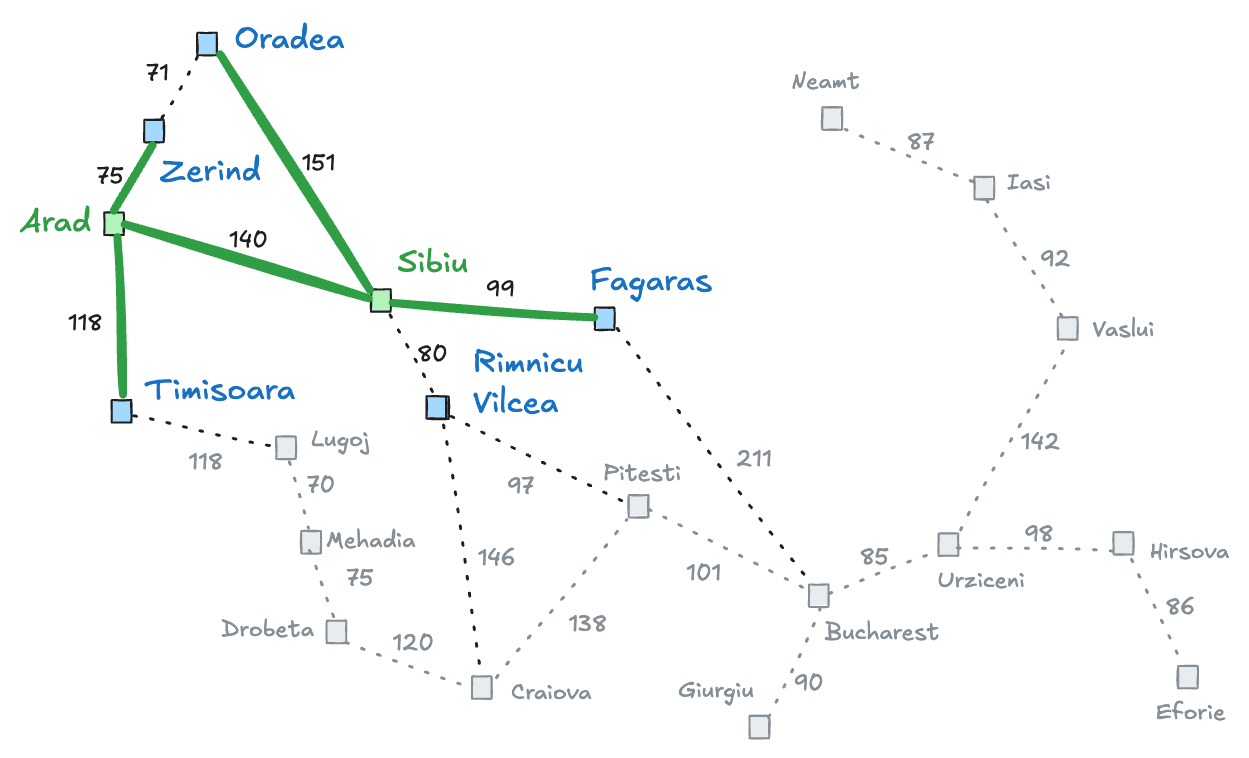

Notice that the frontier separates two regions of the state-space graph: an **interior region** where every state has been expanded, and an **exterior region** of states that have not yet been reached. We can show this property on a rectangular-grid problem:

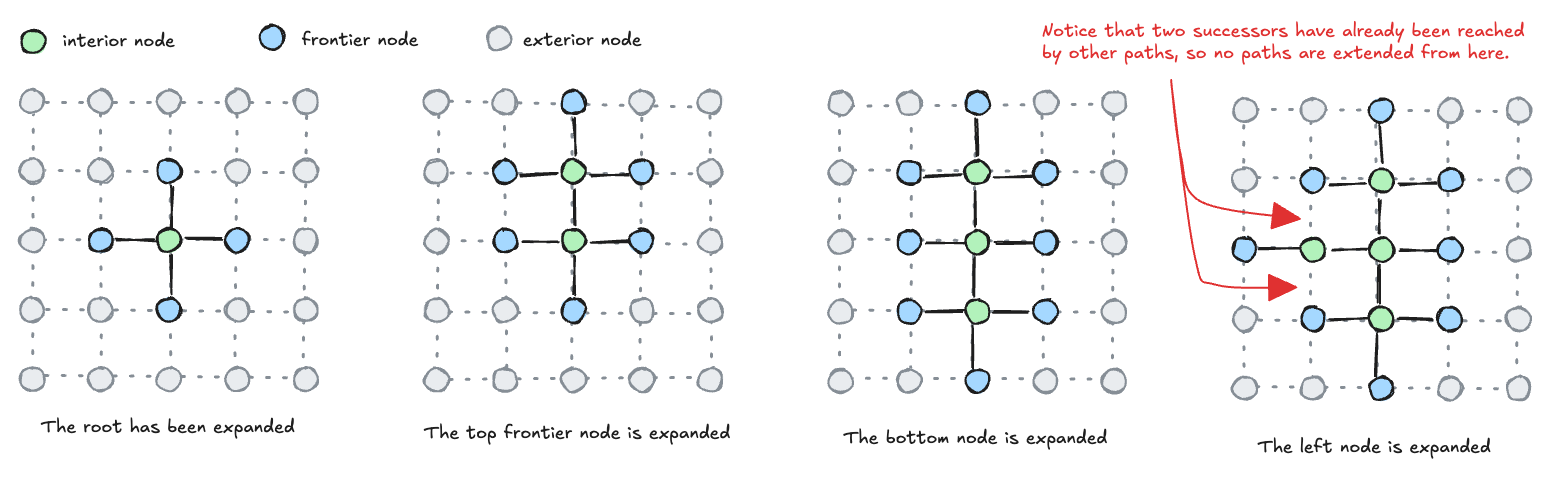

A **search algorithm** manages the frontier, expanding nodes and updating it until a goal state is found. It must also handle **repeated states**, which occur when the same state is reached via different paths. For instance, traveling from Arad to Sibiu and back to Arad forms a **cycle**, making the search tree **infinite** despite a limited state space. More generally, a **redundant path** is an inefficient way to reach the same state, such as taking Arad–Zerind–Oradea–Sibiu (297 miles) instead of Arad–Sibiu (140 miles). There are three ways to handle this:  

- **Track all reached states**, keeping only the best path to each. This is ideal for highly redundant state spaces when memory allows. In this case, the algorithm is called a **graph search**. 
- **Ignore repeats**, leading to a **tree-like search** that may explore redundant paths which avoids them. "Like" because the state space remains a graph, but we choose to treat it as a tree.  
- **Detect cycles only**, using parent pointers to check if a state reappears in its path, requiring no extra memory.

### Measuring performance
 
A search algorithm can be evaluated based on several key criteria.

- **Completeness**: does the algorithm always find a solution when one exists and correctly report failure when none exists? A complete algorithm must systematically explore all reachable states. In finite state spaces, this is straightforward by tracking paths and avoiding cycles. In infinite state spaces, an algorithm must ensure **systematic** exploration, such as using a spiral pattern in a grid. For example, in an infinite grid with no obstacles, moving straight creates an infinite path without revisiting states, but the search is incomplete as many areas remain unexplored. A systematic approach ensures completeness by covering all cells n steps from the origin before expanding to n+1 steps. However, if no solution exists in an infinite space, a complete algorithm must search indefinitely.  

- **Optimality**: does the algorithm find the solution with the lowest path cost among all possible solutions?  

- **Time and space Complexity**: how long does it take to find a solution? This can be measured in execution time or in the number of states and actions considered. How much memory does the algorithm require? Complexity is typically analyzed based on the size of the state-space graph, represented as |V| (states) and |E| (edges). In explicit graphs, like a road map, this is straightforward But in many problems, the graph is represented only implicitly by the initial state, actions, and transition model and the complexity depends on factors such as **maximum path length**, and **branching factor** (number of successors per node).

But how many states does a typical problem have? In a toy example like the **Romania map**, there are only **20 states**, but for the **8-puzzle**, the number grows to **9! (362,880) states**, and in the **15-puzzle**, it reaches **16! (≈1.3 × 10¹²) states**. Even in seemingly simple examples, the state space can be enormous, making it essential to carefully consider space and time complexity. Consequently, it is **generally impossible to explicitly represent the entire state space**. Instead, a problem-solving agent must find a solution by exploring only a small fraction of it.

### Node structure

We need a data structure to represent a node in a tree, defined as a tuple containing several components. It includes the state associated with the node, the parent node from which it was generated, the action applied to the parent state to produce this node, the total cost (denoted as *g*) of the path from the initial state to this node, and the depth of the node in the tree: 

In [142]:
class Node:
    def __init__(self, state, parent=None, action=None, path_cost=0):
        """Initialize a node with a given state, parent, action, path cost, and depth."""
        self.state = state
        self.parent = parent
        self.action = action
        self.path_cost = path_cost  
        self.depth = parent.depth + 1 if parent else 0  

    def child_node(self, action, problem):
        """Generate a child node for a given action."""
        next_state = problem.result(self.state, action)
        return Node(next_state, self, action, problem.path_cost(self.path_cost, self.state, action, next_state))
    
    def expand(self, problem):
        """List the nodes reachable in one step from this node."""
        return [self.child_node(action, problem) for action in problem.actions(self.state)]

    def path(self):
        """Return a list of nodes forming the path from the root to this node."""
        path_back = []
        node = self
        while node:
            path_back.append(node)
            node = node.parent
        return list(reversed(path_back))

    def solution(self):
        """Return the sequence of actions to go from the root to this node."""
        return [n.action for n in self.path()][1:]

To generate a child node, we apply a given action to the current node’s state, determine the resulting state, and compute the new path cost before creating and returning the new node (child_node() method). This process relies on the problem-specific result() and path_cost() functions. Expanding a node (expand() method) involves generating all possible child nodes based on the set of valid actions for the current state, which depends on the problem-specific actions() function. By tracing a node’s parent chain back to the root, we can reconstruct the sequence of states and actions leading to that node (path() methos). When applied to a goal node, this process yields the solution—the sequence of actions taken along the path (solution() method).

### Frontier and  reached states

We need a data structure to store the **frontier states**, and the most suitable choice is a **queue**, as the operations on the frontier typically involve: checking if it is empty, removing the top node, returning the top node, and inserting a new node. A common types of queue used in search algorithms is the **priority queue** whic pops the node with the minimum/maximum cost based on an evaluation function:

In [155]:
import heapq

class PriorityQueue:
    """A Queue in which the minimum (or maximum) element (as determined by f and order) is returned first."""

    def __init__(self, order='min', f=lambda x: x):
        self.heap = []
        if order == 'min':
            self.f = f
        else:
            self.f = lambda x: -f(x)

    def append(self, item):
        """Insert item at its correct position."""
        heapq.heappush(self.heap, (self.f(item), item))

    def extend(self, items):
        """Insert each item in items at its correct position."""
        for item in items:
            self.append(item)

    def pop(self):
        """Pop and return the item (with min or max f(x) value)
        depending on the order."""
        if self.heap:
            return heapq.heappop(self.heap)[1]
        else:
            raise Exception('Trying to pop from empty PriorityQueue.')

    def __len__(self):
        """Return current capacity of PriorityQueue."""
        return len(self.heap)

    def __contains__(self, key):
        """Return True if the key is in PriorityQueue."""
        return any([item == key for _, item in self.heap])

    def __getitem__(self, key):
        """Returns the first value associated with key in PriorityQueue."""
        for value, item in self.heap:
            if item == key:
                return value
        return None

    def __delitem__(self, key):
        """Delete the first occurrence of key."""
        try:
            del self.heap[[item == key for _, item in self.heap].index(True)]
        except ValueError:
            raise KeyError(str(key) + " is not in the priority queue")
        heapq.heapify(self.heap)

The **reached states** can be stored as a lookup table where each key is a state and each value is the node for that state. For example, we can use a set, which is a simple unordered collection of unique elements.

### Best-first search

A general approach for exploring a graph and selecting the next node to expand from the frontier is called **best-first search**. In this method, the node with the minimum value of a given **evaluation function** is chosen for expansion. The evaluation function is problem-specific and may include the path cost, the depth of the node, and a heuristic estimate of the remaining cost to reach the goal. The algorithm is defined as follows:

In [158]:
def best_first_graph_search(f, problem):
    """Search the nodes with the lowest f scores first."""

    # Create the initial node
    node = Node(problem.initial)

    # Create the reached states
    explored = set()

    # Create the frontier and add the initial node  
    frontier = PriorityQueue('min', f)
    frontier.append(node)

    # While the frontier is not empty
    while frontier:

        # Get the node with the highest priority
        node = frontier.pop()

        # Check if we reach the goal, in case return the path
        if problem.goal_test(node.state): 
            return node

        # Add the state to the explored states
        explored.add(node.state)

        # Expand the node and add the children to the frontier
        for child in node.expand(problem):
            # Append the child to the frontier if it is 
            # not in the explored states or in the frontier
            if child.state not in explored and child not in frontier:
                frontier.append(child)
            # otherwise, if the child is in the frontier and 
            # has a lower f score, update the frontier
            elif child in frontier:
                if f(child) < frontier[child]:
                    del frontier[child]
                    frontier.append(child)

    # If the frontier is empty and we did not reach the goal, return None
    # there is no solution
    return None


At each iteration, the algorithm selects the frontier node with the lowest evaluation value. If it is a goal, the path is returned; otherwise, the node is expanded. New child are added to the frontier unless already reached, in which case they are re-added only if a better path is found. The algorithm either finds a solution or fails. This is a graph search, as it tracks reached states. Removing this tracking results in a tree-like search, which uses less memory but explores redundant paths, making it slower.

## Uninformed Search Strategies

An **uninformed search** lacks any knowledge of how close a state is to the goal. For example, an agent in Arad trying to reach Bucharest, without knowledge of Romanian geography, cannot judge whether Zerind or Sibiu is a better first step. In contrast, an **informed search** uses knowledge, such as city locations, to prioritize moves—favoring Sibiu as it is closer to Bucharest. Uninformed search strategies are simpler and more general, but may be less efficient. Here are we consider some common uninformed search strategies.

### Breadth-first search

When all actions have the same cost, **breadth-first search** is an effective strategy. It expands the root first, then its successors, followed by their successors, one by one. This systematic approach ensures completeness, even in infinite state spaces. For example, in a binary tree, the search progresses level by level:

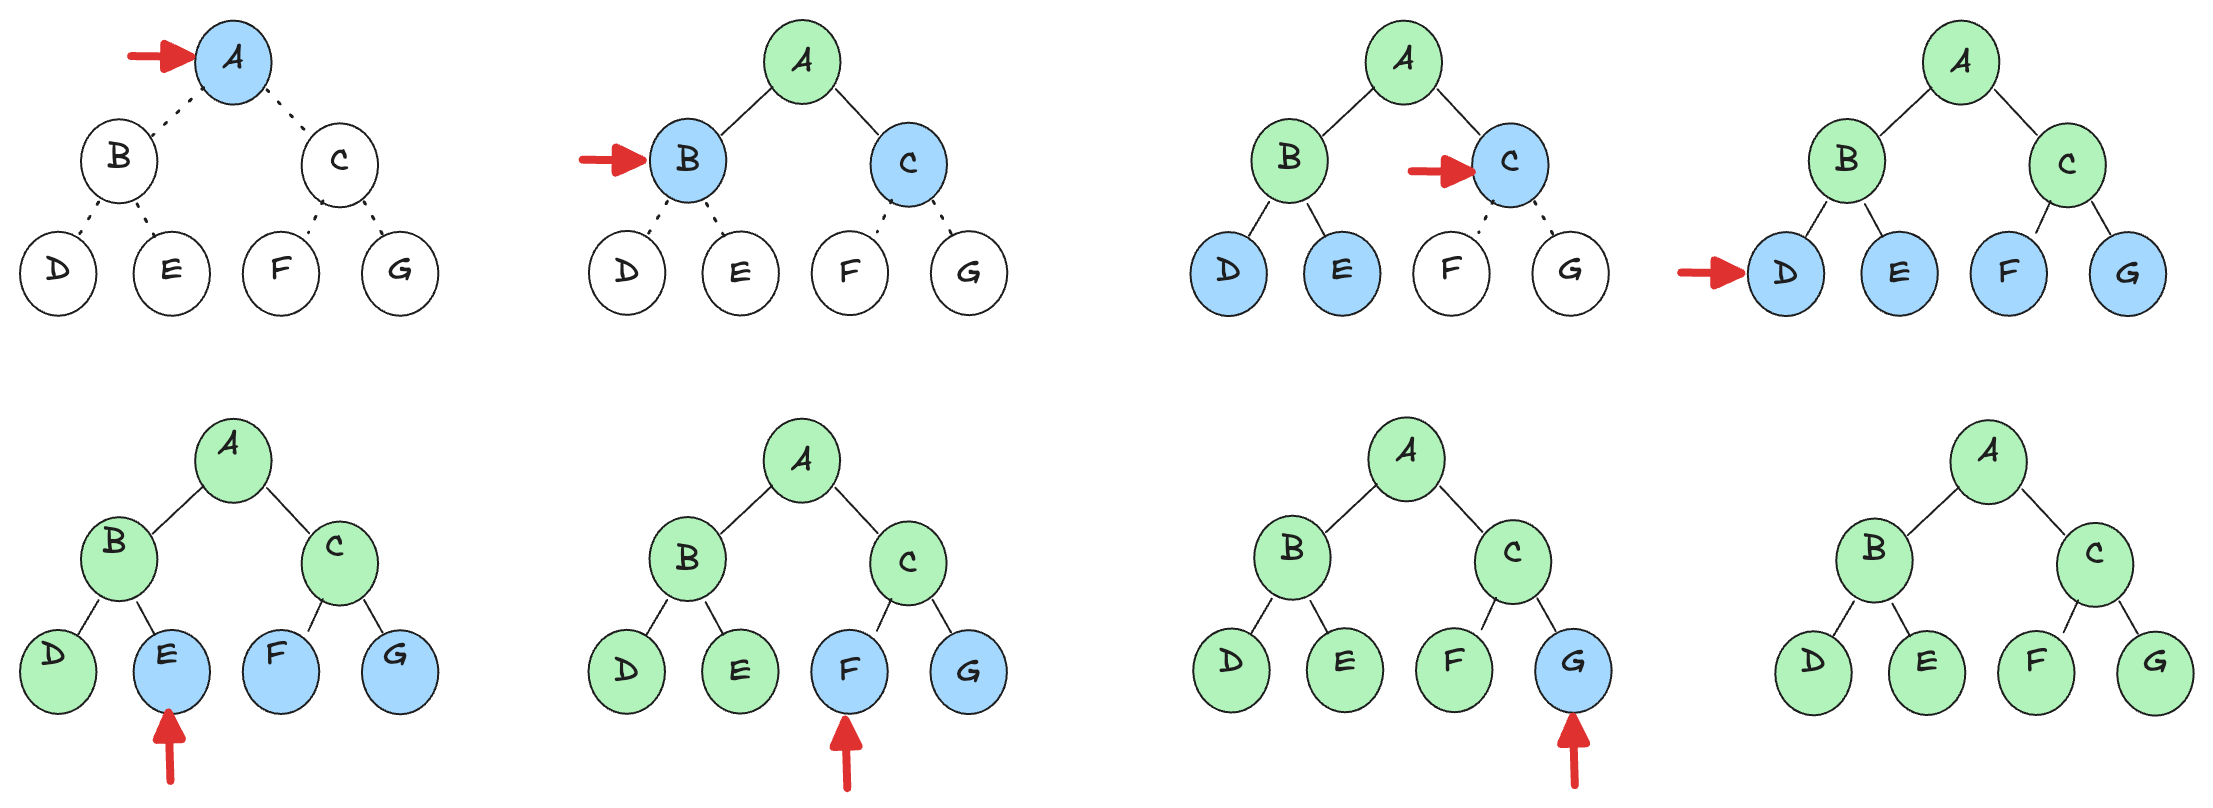

Breadth-first search can be seen as best-first search with an evaluation function based on node depth. However, it can be optimized with a **FIFO queue** instead of a priority queue. New nodes (which are always deeper than their parents) go to the back of the queue, and old nodes, which are shallower than the new nodes, get expanded first. We can perform an **early goal test**, checking if a node is a solution immediately upon generation, instead of waiting for the node to be popped from the queue:

In [145]:
from collections import deque

def breadth_first_graph_search(problem):
    
    # Create the initial node
    node = Node(problem.initial)

    # Early goal test
    if problem.goal_test(node.state):
        return node

    # Add the node to the frontier    
    frontier = deque([node])

    # Create the explored states
    explored = set()

    # While the frontier is not empty
    while frontier:
        # Get the node from the frontier
        node = frontier.popleft()
        
        # Add the state to the explored states
        explored.add(node.state)

        # Print some info during the search
        print("\rNumber of explored states: ", len(explored), end="")

        # Expand the node and add the children to the frontier
        for child in node.expand(problem):
            if child.state not in explored and child not in frontier:
                # Early goal test
                if problem.goal_test(child.state):
                    return child
                # Add the child to the frontier    
                frontier.append(child)
                
    # If the frontier is empty and we did not reach the goal, return None            
    return None

We can solve the Arad-Bucharest problem using breadth-first search:

In [146]:
bfs = breadth_first_graph_search(romania_problem)
bfs.solution()

Number of explored states:  8

['Sibiu', 'Fagaras', 'Bucharest']

In [147]:
puzzle = EightPuzzle((1, 2, 3, 
                      4, 5, 6, 
                      0, 7, 8))
bfs = breadth_first_graph_search(puzzle)
bfs.solution()

Number of explored states:  3

['RIGHT', 'RIGHT']

However, not all configurations of the 8-puzzle are solvable. In particular, it is possible to demonstrate that whether a configuration is solvable depends on a mathematical property called **parity**, which is determined by the number of inversions in the tile sequence. In that case, the algorithm has trouble finding a solution (that don't exist) and has to explore the entire state space. The following code may take some time to execute, depending on your hardware, proceed with caution:

In [148]:
puzzle = EightPuzzle((1, 2, 3, 
                      4, 5, 6, 
                      8, 7, 0))
bfs = breadth_first_graph_search(puzzle)

if(bfs != None):
    print(bfs.solution())
else:
    print("\nNo solution found!")
    

Number of explored states:  1814406510676 33960558936677488290 88558108314 111435 120364126434 137515 154931 160058 163537168710 169786 170808174987180417
No solution found!


Breadth-first search guarantees a solution with **a minimal number of actions**, because when it is generating nodes at depth d, it has already generated all the nodes at depth d−1, so if one of them were a solution, it would have been found. This makes it **optimal** when all actions have the same cost, but not in cases with varying costs (Indeed in the Romania problem it find a path with a minimum number of action, but not the optimal path in terms of cost). It remains **complete** regardless.  

In terms of time and space, imagine searching a uniform tree where every state has b successors. The root generates b nodes, each of which generates b more nodes, for a total of b^2 at the second level. Each of these generates b more nodes, yielding b^3 nodes at the third level, and so on. Now suppose that the solution is at depth d. Then the total number of nodes generated is:

$\displaystyle 1+b+b^2+b^3+· · ·+b^d = O(b^d)$

All the nodes remain in memory, so both time and space complexity are O(b^d). Exponential bounds like that are a problem. As a typical real-world example, consider a problem with branching factor b=10, processing speed 1 million nodes/second, and memory requirements of 1 KB/node. A search to depth d=10 would take less than 3 hours, but would require 10 TB of memory. The memory requirements are a bigger problem for breadth-first search than the execution time. But time is still an important factor. At depth d=14, even with infinite memory, the search would take 3.5 years. This scenario highlights how, in practical applications, such as the 8-puzzle, which can have many unsolvable configurations, the search space grows exponentially, rendering uninformed search strategies ineffective for anything but the smallest instances.

In general, **exponential-complexity search problems**, such as searching for a solution to a non-solvable 8-puzzle, cannot be efficiently tackled using uninformed search methods for most instances due to their extensive time and memory requirements.

As an exercise, we can try to solve the N-queens problem:

In [149]:
queens = NQueensProblem(8)
bfs = breadth_first_graph_search(queens)
bfs.solution()

Number of explored states:  1665

[0, 4, 7, 5, 2, 6, 1, 3]

Verify on a chessboard whether this is a valid solution

### Uniform-cost algorithm

When actions have **different costs**, an obvious choice is to use best-first search where the evaluation function is the cost of the path from the root to the current node. This is called **uniform-cost algorithm** (or **Dijkstra’s search**). The idea is that while breadth-first search spreads out in waves of uniform depth (first depth 1, then depth 2, and so on), uniform-cost search spreads out in waves of uniform path-cost. Consider the following example to undestand the algorithm:

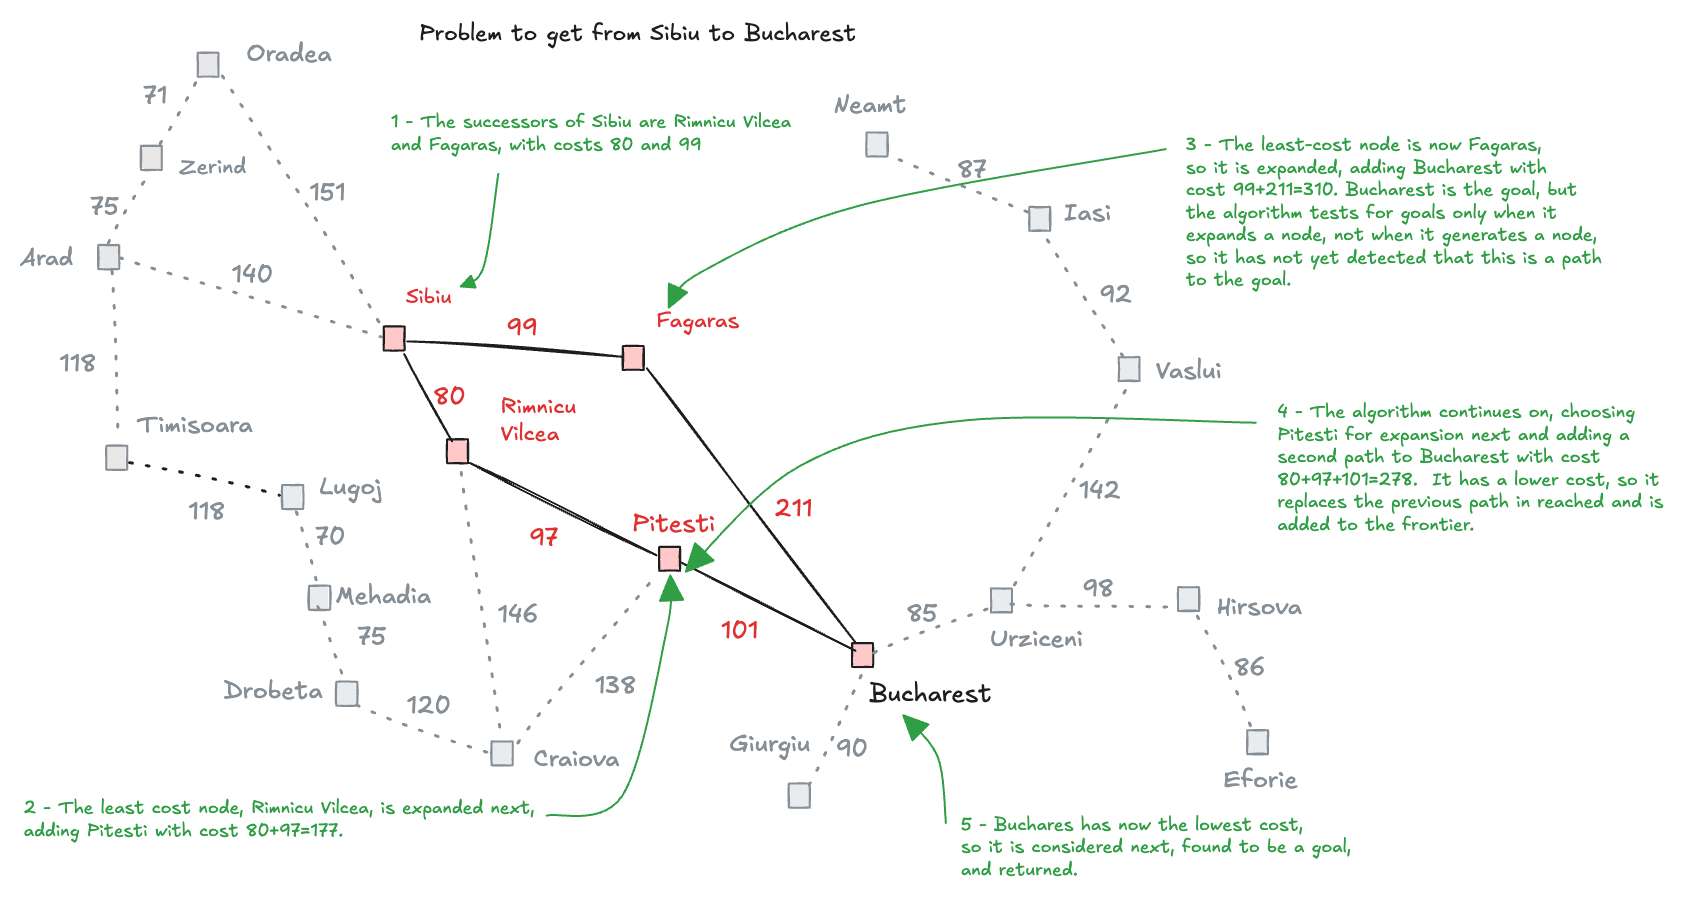

Note that if we had checked for a goal upon generating a node rather than when expanding the lowest-cost node, then we would have returned a higher-cost path. The algorithm can be implemented as a best-first with the path cost as the evaluation function:

In [159]:
def uniform_cost_search(problem):
    """Search the node of least total cost first."""
    return best_first_graph_search(lambda node: node.path_cost, problem)

We can run the algotithm on the Arad-Bucharest problem in order to see if it finds the optimal path:

In [161]:
ucs = uniform_cost_search(romania_problem)
ucs.solution()

['Sibiu', 'Rimnicu Vilcea', 'Pitesti', 'Bucharest']

Uniform-cost search expands nodes based on **cumulative path cost** rather than depth, ensuring **optimality** even when action costs vary. However, it may expand many **low-cost nodes** before reaching the goal. Let C be the optimal solution cost and $\epsilon > 0$ the smallest action cost. In the worst case, the search takes **smallest possible steps**, requiring at most:  

$\displaystyle d_{\max} = \frac{C}{\epsilon}$

Additionally, it explores the next level* of nodes before stopping, leading to a complexity of:

$\displaystyle O\left(b^{1 + \frac{C}{\epsilon} }\right)$

This can far exceed $O(b^d)$ because uniform-cost may explore large trees of **cheap actions** before considering **high-cost but useful** ones. When all actions have equal cost, it simplifies to $O(b^{d+1})$, behaving like breadth-first search. Despite its cost, the algorithm is **complete** (as long as all action costs are positive) and **optimal**, since it expands paths in increasing cost order, never getting trapped in an infinite sequence of low-cost actions.

### Depth-first search

Depth-first search always expands the deepest node in the frontier first and explores as far as possible along one branch before backtracking. The search then "backs up" to the next deepest node that still has unexpanded successors. It uses a last-in, first-out strategy, typically implemented with a stack. When expanding a node, it pushes all its successors onto the stack and continues with the most recently added node. If a dead-end is reached (i.e., a node with no unvisited successors), it backtracks to the last explored node with remaining paths. This process continues until a solution is found or all possible paths are exhausted:

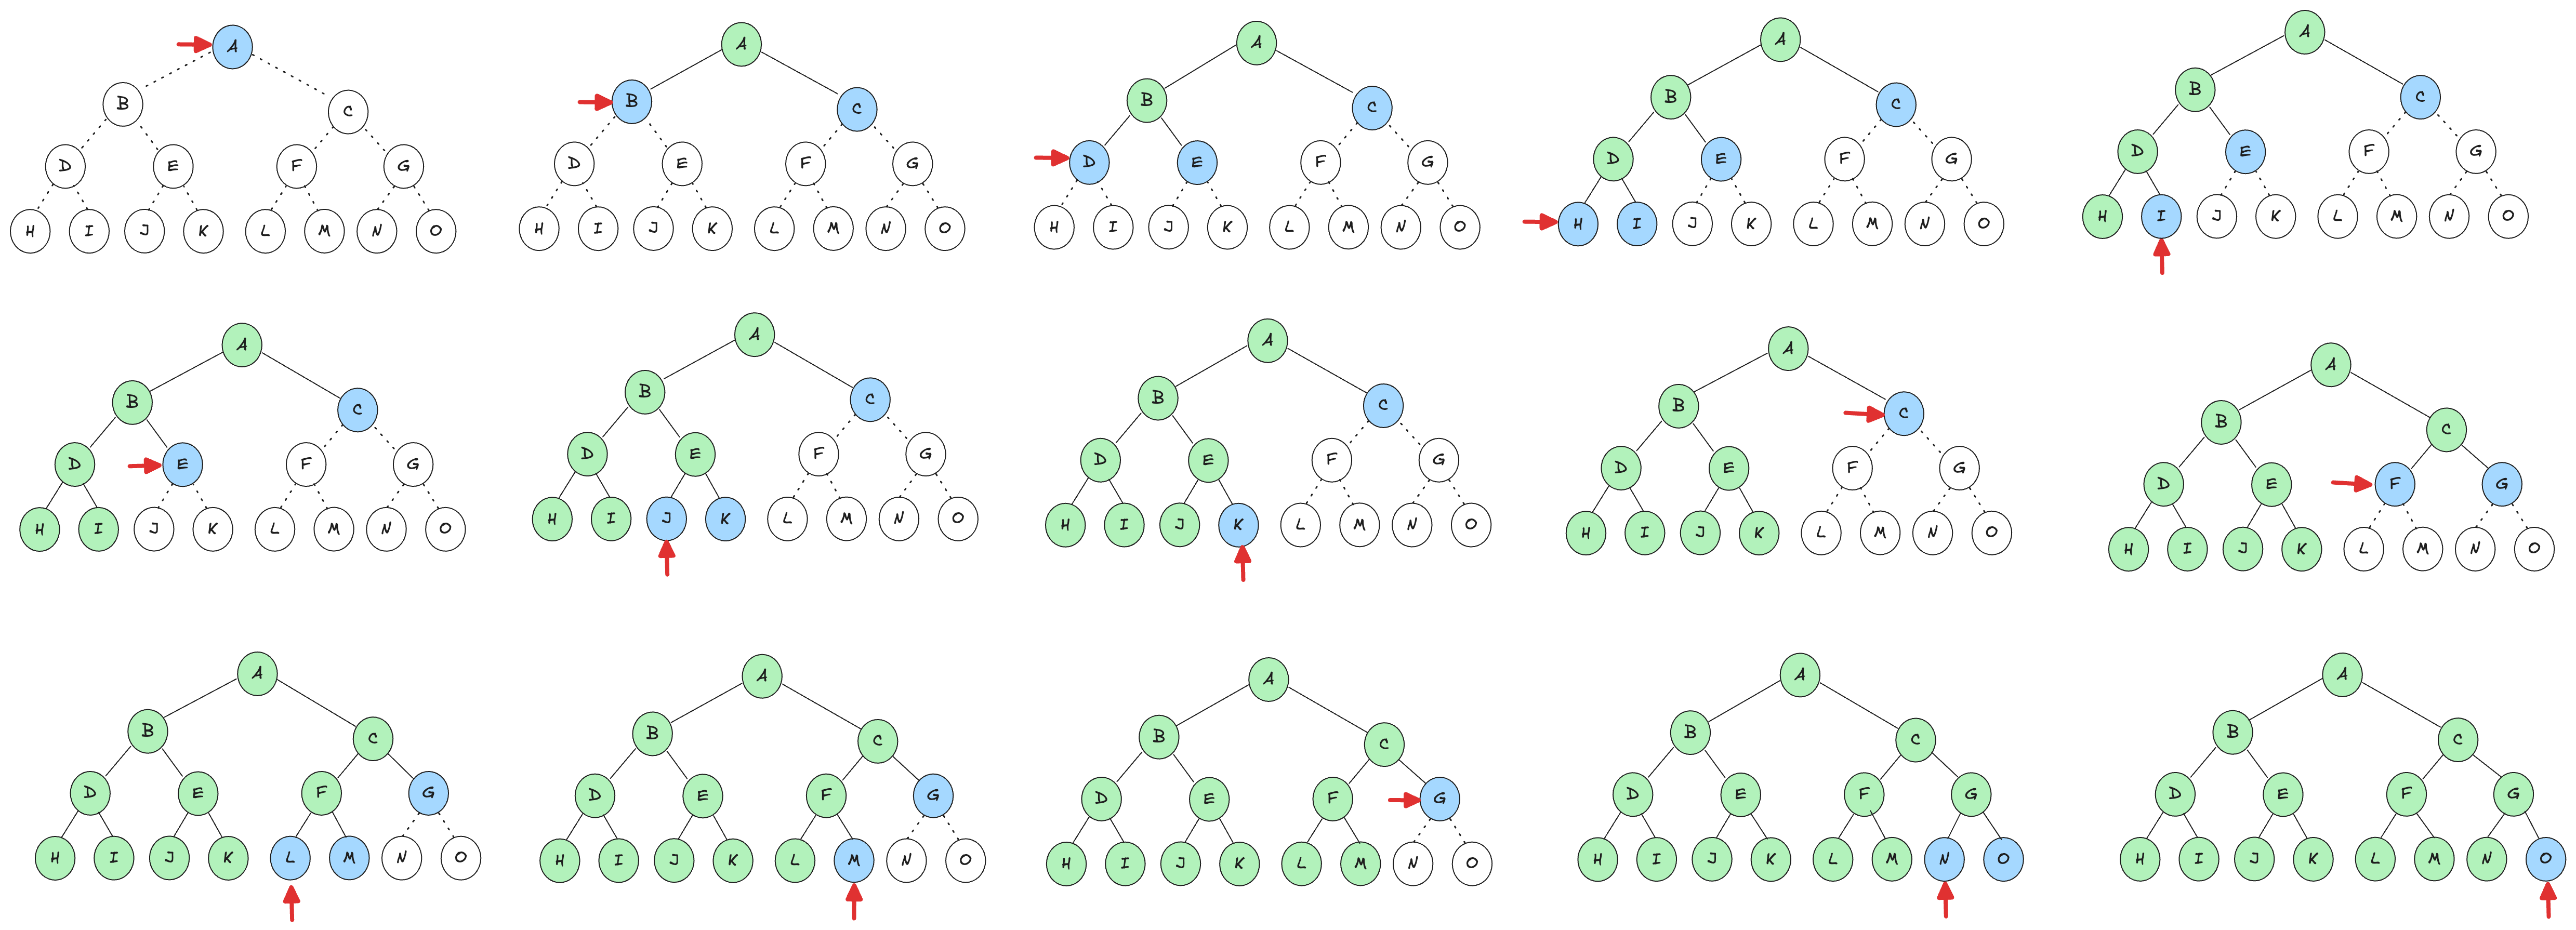

It could be implemented as best-first where the evaluation function is the negative of the depth. However, it is usually implemented as a tree-like search that does not keep a table of reached states:

In [162]:
def depth_first_tree_search(problem):
    """Search the deepest nodes in the search tree first."""
    
    # Create the initial node
    node = Node(problem.initial)

    # Create the frontier as a stack
    frontier = [node]

    # While the frontier is not empty
    while frontier:
        # Get the node from the frontier
        node = frontier.pop()

        # Print the current state
        print("Considering state: ", node.state)

        # If the node is a goal, return the path
        if problem.goal_test(node.state):
            return node

        # Add the children to the frontier
        frontier.extend(node.expand(problem))
    
    # If the frontier is empty and we did not reach the goal, return None
    return None

We run the algorithm on the Arad-Bucharest problem:

In [164]:
dfs = depth_first_tree_search(romania_problem)
dfs.solution()

Considering state:  Arad
Considering state:  Sibiu
Considering state:  Fagaras
Considering state:  Bucharest


['Sibiu', 'Fagaras', 'Bucharest']

We can see that depth-first goes directly to a solution in that case, since it explores the first branch completely before moving to the next, and in that particular case it find the goal. However this can be not **not optimal** since it returns the first solution it finds, regardless of cost. It is **complete** only in finite tree-shaped spaces, but may expand the same state multiple times in acyclic graphs. In cyclic or infinite spaces, it can also **get stuck in loops or follow an infinite path**, making it **incomplete** without cycle detection. Despite these drawbacks, depth-first search is useful for its **low memory usage**. Unlike breadth-first search, which stores an expanding frontier, it only tracks the current path, requiring just $O(bm)$ memory. Think of the frontier in breadth-first search as the surface of an ever-expanding sphere, while the frontier in depth-first search is just a radius of the sphere. This efficiency makes breadth-first search practical for large problems where others algorithms would be infeasible due to excessive memory demands.